# Thuật Toán Tối Ưu Đàn Kiến - Phân Tích Toàn Diện Các Tham Số

## Tổng quan

Notebook này phân tích chi tiết 5 tham số chính của thuật toán ACO:
1. **Alpha** - Tầm quan trọng của pheromone
2. **Beta** - Tầm quan trọng của heuristic (khoảng cách)
3. **Rho** - Tốc độ bay hơi pheromone
4. **Num_ant** - Số lượng kiến trong đàn
5. **Q** - Hằng số cường độ pheromone

Mỗi tham số được phân tích với 4 yêu cầu:
- Khả năng hội tụ (Convergence Ability)
- So sánh hiệu suất (Comparative Performance)
- Độ nhạy tham số (Parameter Sensitivity)
- Bề mặt 3D (3D Surface)

## Thư viện sử dụng
- Matplotlib: Vẽ biểu đồ
- Seaborn: Phân tích và visualization thống kê

In [ ]:
# swarm algorithms imports
from swarm_algo.aco import AntColonyOptimizer

# traditional algorithms imports
from search_algo.genetic import GeneticAlgorithm as GA
from search_algo.bfs import BreadthFirstSearch as BFS
from search_algo.dfs import DepthFirstSearch as DFS

# problem imports
from problem.knapsack import Knapsack

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# utility imports
import random
import time
import logging
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## Định nghĩa lớp AntColonyOptimizer

In [2]:
TSP_DATA_FOLDER = "../data/tsp/"

In [3]:
def get_problem_infos(PROBLEM: int) -> Tuple[np.ndarray, List[int]]:
    """
    Load TSP problem data
    Returns:
        - distance_matrix: 2D array of distances between cities
        - solution: optimal solution path
    """
    problem = f"p{PROBLEM:02d}"

    # Read distance matrix
    with open(TSP_DATA_FOLDER + problem + "_d.txt") as f:
        lines = f.readlines()
        distance_matrix = []
        for line in lines:
            row = [float(x) for x in line.split()]
            distance_matrix.append(row)
        distance_matrix = np.array(distance_matrix)

    # Read solution path
    with open(TSP_DATA_FOLDER + problem + "_s.txt") as f:
        # Convert to 0-indexed
        solution = [int(s.strip()) - 1 for s in f.readlines()]

    return distance_matrix, solution

PROBLEM = 4
distance_matrix, solution = get_problem_infos(PROBLEM)
num_colonies = len(distance_matrix)
cities = np.array([[i, 0] for i in range(num_colonies)])


## Hàm tiện ích để tạo các biểu đồ

In [4]:
def plot_convergence(results, param_name, save_name):
    """Vẽ biểu đồ khả năng hội tụ"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
    
    ax1 = axes[0, 0]
    for r, color in zip(results, colors):
        ax1.plot(r['best_history'], label=r['label'], linewidth=2.5, color=color)
    ax1.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
    ax1.set_title('Hội tụ - Nghiệm tốt nhất', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    for r, color in zip(results, colors):
        ax2.plot(r['avg_history'], label=r['label'], linewidth=2.5, color=color, alpha=0.8)
    ax2.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Fitness trung bình', fontsize=12, fontweight='bold')
    ax2.set_title('Hội tụ - Quần thể trung bình', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    for r, color in zip(results, colors):
        ax3.plot(r['diversity'], label=r['label'], linewidth=2.5, color=color, alpha=0.8)
    ax3.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Độ đa dạng', fontsize=12, fontweight='bold')
    ax3.set_title('Độ đa dạng nghiệm', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    improvement_rates = []
    labels = []
    for r in results:
        history = r['best_history']
        rate = (history[0] - history[-1]) / len(history)
        improvement_rates.append(rate)
        labels.append(r['short_label'])
    bars = ax4.bar(range(len(labels)), improvement_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_xticks(range(len(labels)))
    ax4.set_xticklabels(labels, fontsize=11)
    ax4.set_ylabel('Tốc độ cải thiện', fontsize=12, fontweight='bold')
    ax4.set_title('Tốc độ cải thiện trung bình', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, improvement_rates):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'{param_name} - Phân tích khả năng hội tụ', fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{save_name}_1_hoi_tu.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_comparative(results, param_name, save_name):
    """Vẽ biểu đồ so sánh hiệu suất"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
    labels_short = [r['short_label'] for r in results]
    
    best_fits = [r['best_fitness'] for r in results]
    conv_speeds = []
    stabilities = []
    final_divs = []
    
    for r in results:
        history = r['best_history']
        target = history[-1] * 1.05
        try:
            speed = next(i for i, v in enumerate(history) if v <= target)
        except:
            speed = len(history)
        conv_speeds.append(speed)
        stabilities.append(np.std(history[-20:]))
        final_divs.append(r['diversity'][-1])
    
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(labels_short)), best_fits, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_xticks(range(len(labels_short)))
    ax1.set_xticklabels(labels_short)
    ax1.set_ylabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
    ax1.set_title('So sánh fitness', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, best_fits):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2 = axes[0, 1]
    bars = ax2.bar(range(len(labels_short)), conv_speeds, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_xticks(range(len(labels_short)))
    ax2.set_xticklabels(labels_short)
    ax2.set_ylabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax2.set_title('Tốc độ hội tụ', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, conv_speeds):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{int(val)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax3 = axes[0, 2]
    bars = ax3.bar(range(len(labels_short)), stabilities, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax3.set_xticks(range(len(labels_short)))
    ax3.set_xticklabels(labels_short)
    ax3.set_ylabel('Độ lệch chuẩn', fontsize=12, fontweight='bold')
    ax3.set_title('Độ ổn định', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, stabilities):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax4 = axes[1, 0]
    last_20 = [r['best_history'][-20:] for r in results]
    bp = ax4.boxplot(last_20, labels=labels_short, patch_artist=True, widths=0.6)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax4.set_ylabel('Fitness', fontsize=12, fontweight='bold')
    ax4.set_title('Tính nhất quán', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    ax5 = axes[1, 1]
    for r, color in zip(results, colors):
        ax5.plot(r['best_history'], label=r['short_label'], linewidth=2.5, color=color)
    ax5.set_xlabel('Số lần lặp', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Fitness tốt nhất', fontsize=12, fontweight='bold')
    ax5.set_title('Đường hội tụ', fontsize=13, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    ax6 = axes[1, 2]
    bars = ax6.bar(range(len(labels_short)), final_divs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax6.set_xticks(range(len(labels_short)))
    ax6.set_xticklabels(labels_short)
    ax6.set_ylabel('Độ đa dạng', fontsize=12, fontweight='bold')
    ax6.set_title('Độ đa dạng cuối', fontsize=13, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, final_divs):
        ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'{param_name} - So sánh hiệu suất', fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{save_name}_2_so_sanh.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_sensitivity(param_values, sens_results, param_name, save_name):
    """Vẽ biểu đồ độ nhạy tham số"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    best_fits = [r['best_fitness'] for r in sens_results]
    conv_rates = [(r['history'][0] - r['history'][-1]) / len(r['history']) for r in sens_results]
    stabs = [np.std(r['history'][-20:]) for r in sens_results]
    
    ax1 = axes[0, 0]
    ax1.plot(param_values, best_fits, 'o-', linewidth=3, markersize=12,
            color='#E63946', markerfacecolor='#457B9D', markeredgewidth=2, markeredgecolor='black')
    opt_idx = np.argmin(best_fits)
    ax1.plot(param_values[opt_idx], best_fits[opt_idx], 'g*', markersize=25,
            label=f'Tối ưu: {param_values[opt_idx]:.2f}', zorder=5)
    ax1.set_xlabel(f'Giá trị {param_name}', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Fitness tốt nhất', fontsize=13, fontweight='bold')
    ax1.set_title(f'Fitness theo {param_name}', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    ax2.plot(param_values, conv_rates, 's-', linewidth=3, markersize=12,
            color='#F1FAEE', markerfacecolor='#A8DADC', markeredgewidth=2, markeredgecolor='black')
    ax2.set_xlabel(f'Giá trị {param_name}', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Tốc độ hội tụ', fontsize=13, fontweight='bold')
    ax2.set_title(f'Tốc độ hội tụ theo {param_name}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    ax3.plot(param_values, stabs, '^-', linewidth=3, markersize=12,
            color='#06A77D', markerfacecolor='#005F73', markeredgewidth=2, markeredgecolor='black')
    ax3.axhline(y=np.mean(stabs), color='r', linestyle='--', linewidth=2, alpha=0.7, label='Trung bình')
    ax3.set_xlabel(f'Giá trị {param_name}', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Độ ổn định', fontsize=13, fontweight='bold')
    ax3.set_title(f'Độ ổn định theo {param_name}', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    max_len = max(len(r['history']) for r in sens_results)
    heatmap_data = []
    for r in sens_results:
        history = r['history']
        if len(history) < max_len:
            x_old = np.linspace(0, 1, len(history))
            x_new = np.linspace(0, 1, max_len)
            history = np.interp(x_new, x_old, history)
        heatmap_data.append(history)
    im = ax4.imshow(np.array(heatmap_data), aspect='auto', cmap='YlOrRd', interpolation='bilinear')
    ax4.set_xlabel('Số lần lặp', fontsize=13, fontweight='bold')
    ax4.set_ylabel(f'Giá trị {param_name}', fontsize=13, fontweight='bold')
    ax4.set_yticks(range(len(param_values)))
    ax4.set_yticklabels([f'{v:.1f}' if isinstance(v, float) else str(v) for v in param_values])
    ax4.set_title('Bản đồ nhiệt hội tụ', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax4, label='Fitness')
    
    plt.suptitle(f'{param_name} - Độ nhạy tham số', fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'{save_name}_3_do_nhay.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_3d_surface(range1, range2, grid, name1, name2, save_name):
    """Vẽ bề mặt 3D"""
    fig = plt.figure(figsize=(18, 8))
    
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(range2, range1)
    surf = ax1.plot_surface(X, Y, grid, cmap='viridis', alpha=0.9, antialiased=True, edgecolor='none')
    ax1.set_xlabel(name2, fontsize=12, fontweight='bold')
    ax1.set_ylabel(name1, fontsize=12, fontweight='bold')
    ax1.set_zlabel('Fitness', fontsize=12, fontweight='bold')
    ax1.set_title(f'Bề mặt 3D: Fitness({name1}, {name2})', fontsize=14, fontweight='bold')
    ax1.view_init(elev=25, azim=45)
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, grid, levels=20, cmap='viridis', alpha=0.9)
    lines = ax2.contour(X, Y, grid, levels=10, colors='white', linewidths=0.8, alpha=0.6)
    ax2.clabel(lines, inline=True, fontsize=9, fmt='%.1f')
    ax2.set_xlabel(name2, fontsize=13, fontweight='bold')
    ax2.set_ylabel(name1, fontsize=13, fontweight='bold')
    ax2.set_title(f'Đường đồng mức: Fitness({name1}, {name2})', fontsize=14, fontweight='bold')
    fig.colorbar(contour, ax=ax2, label='Fitness')
    
    min_idx = np.unravel_index(np.argmin(grid), grid.shape)
    opt1 = range1[min_idx[0]]
    opt2 = range2[min_idx[1]]
    ax2.plot(opt2, opt1, 'r*', markersize=25, 
            label=f'Tối ưu ({name1}={opt1:.2f}, {name2}={opt2:.2f})', zorder=5)
    ax2.legend(fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Bề mặt 3D - Tương tác {name1} x {name2}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'{save_name}_4_be_mat_3d.png', dpi=300, bbox_inches='tight')
    plt.show()

---
# PHẦN 1: PHÂN TÍCH THAM SỐ ALPHA

Alpha điều khiển tầm quan trọng của pheromone trong quyết định.
- Alpha cao: Tin tưởng vào pheromone (khai thác)
- Alpha thấp: Khám phá nhiều hơn (thăm dò)

Bắt đầu phân tích ALPHA

1. Phân tích khả năng hội tụ


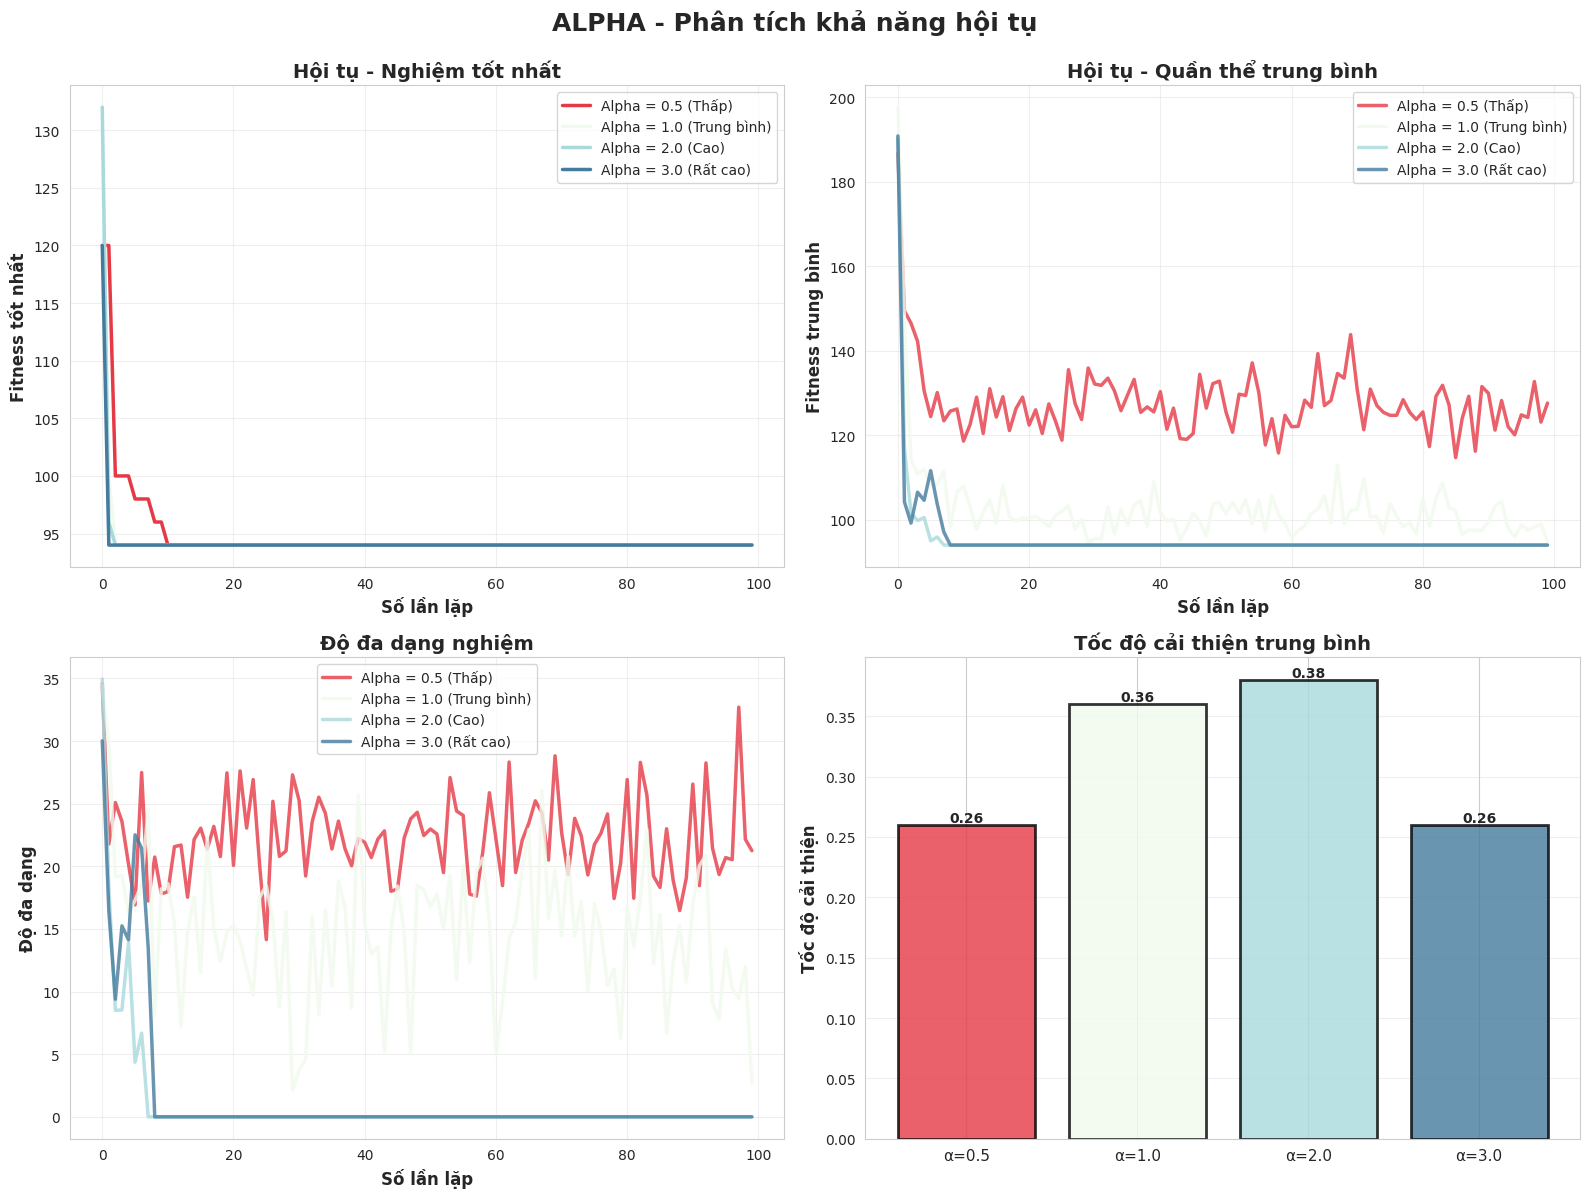


2. So sánh hiệu suất


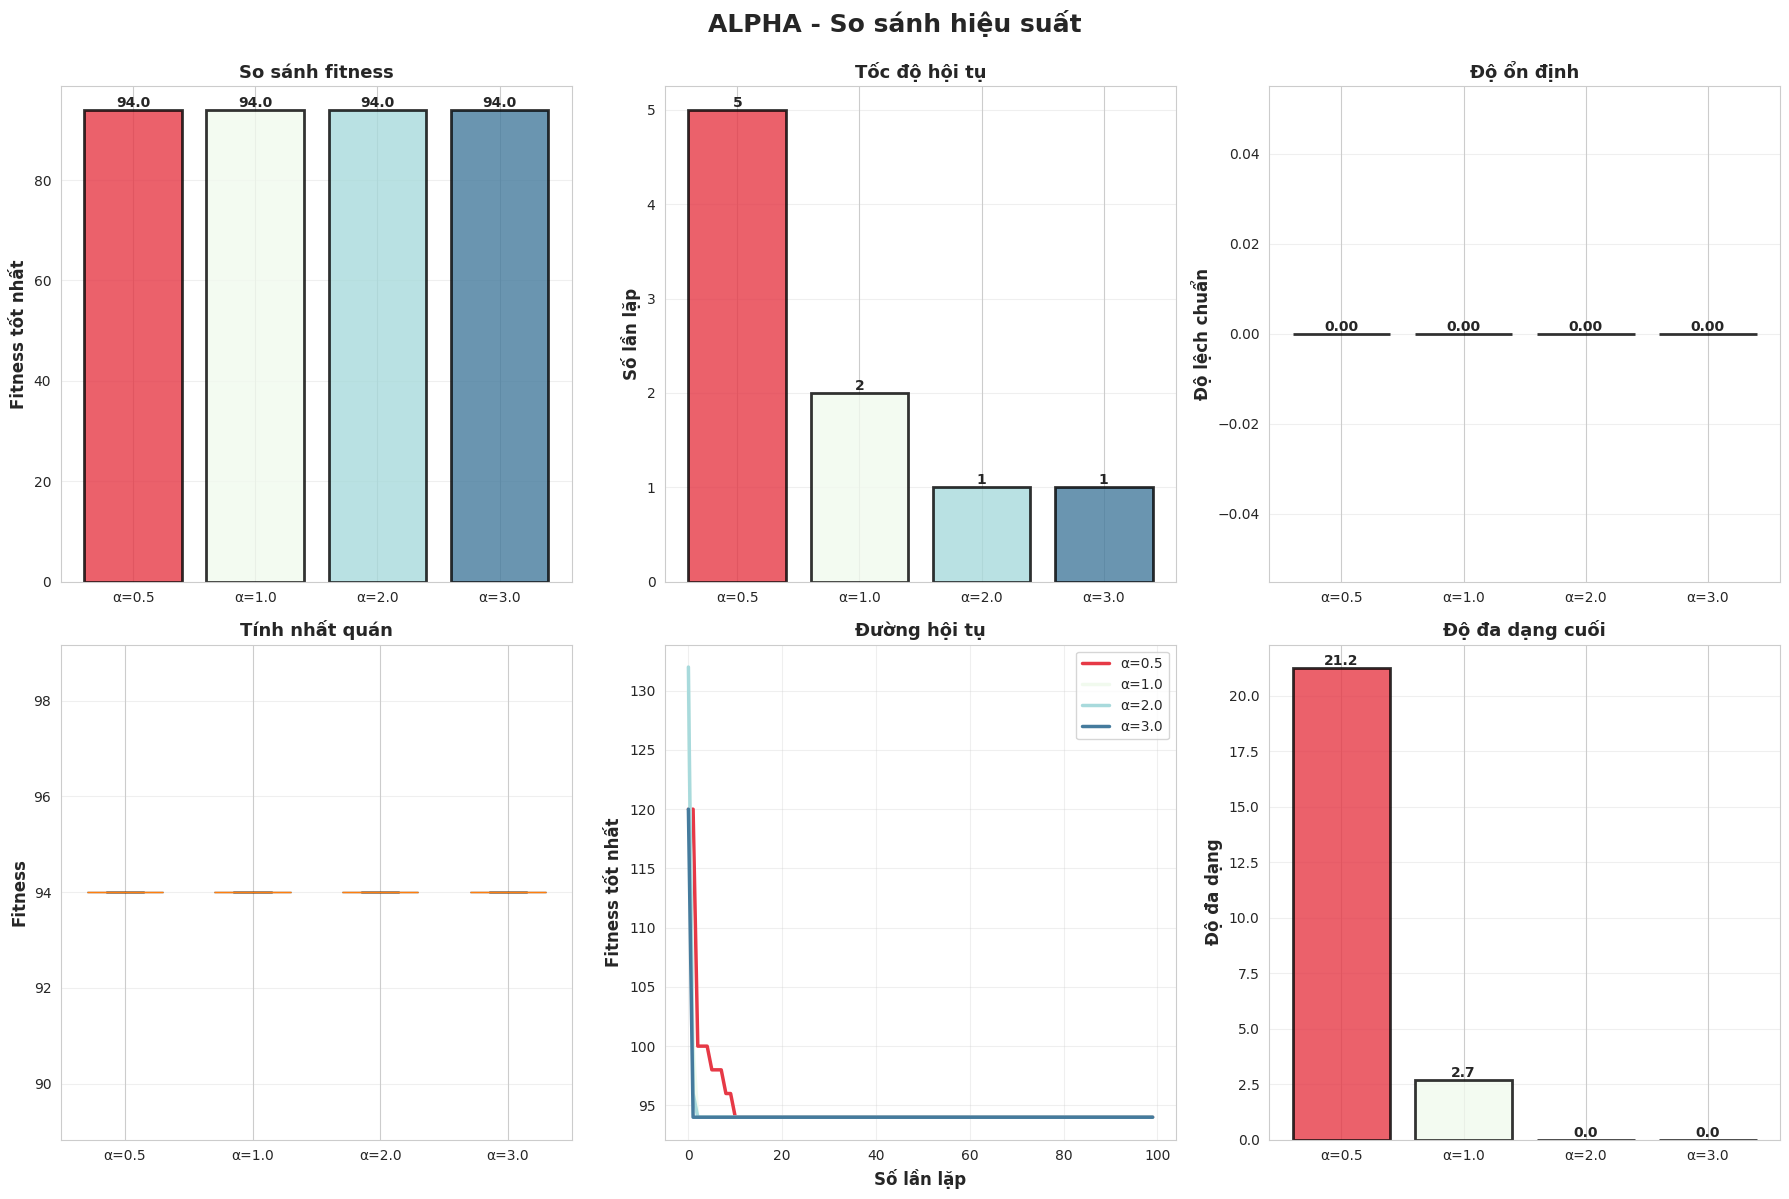


3. Độ nhạy tham số


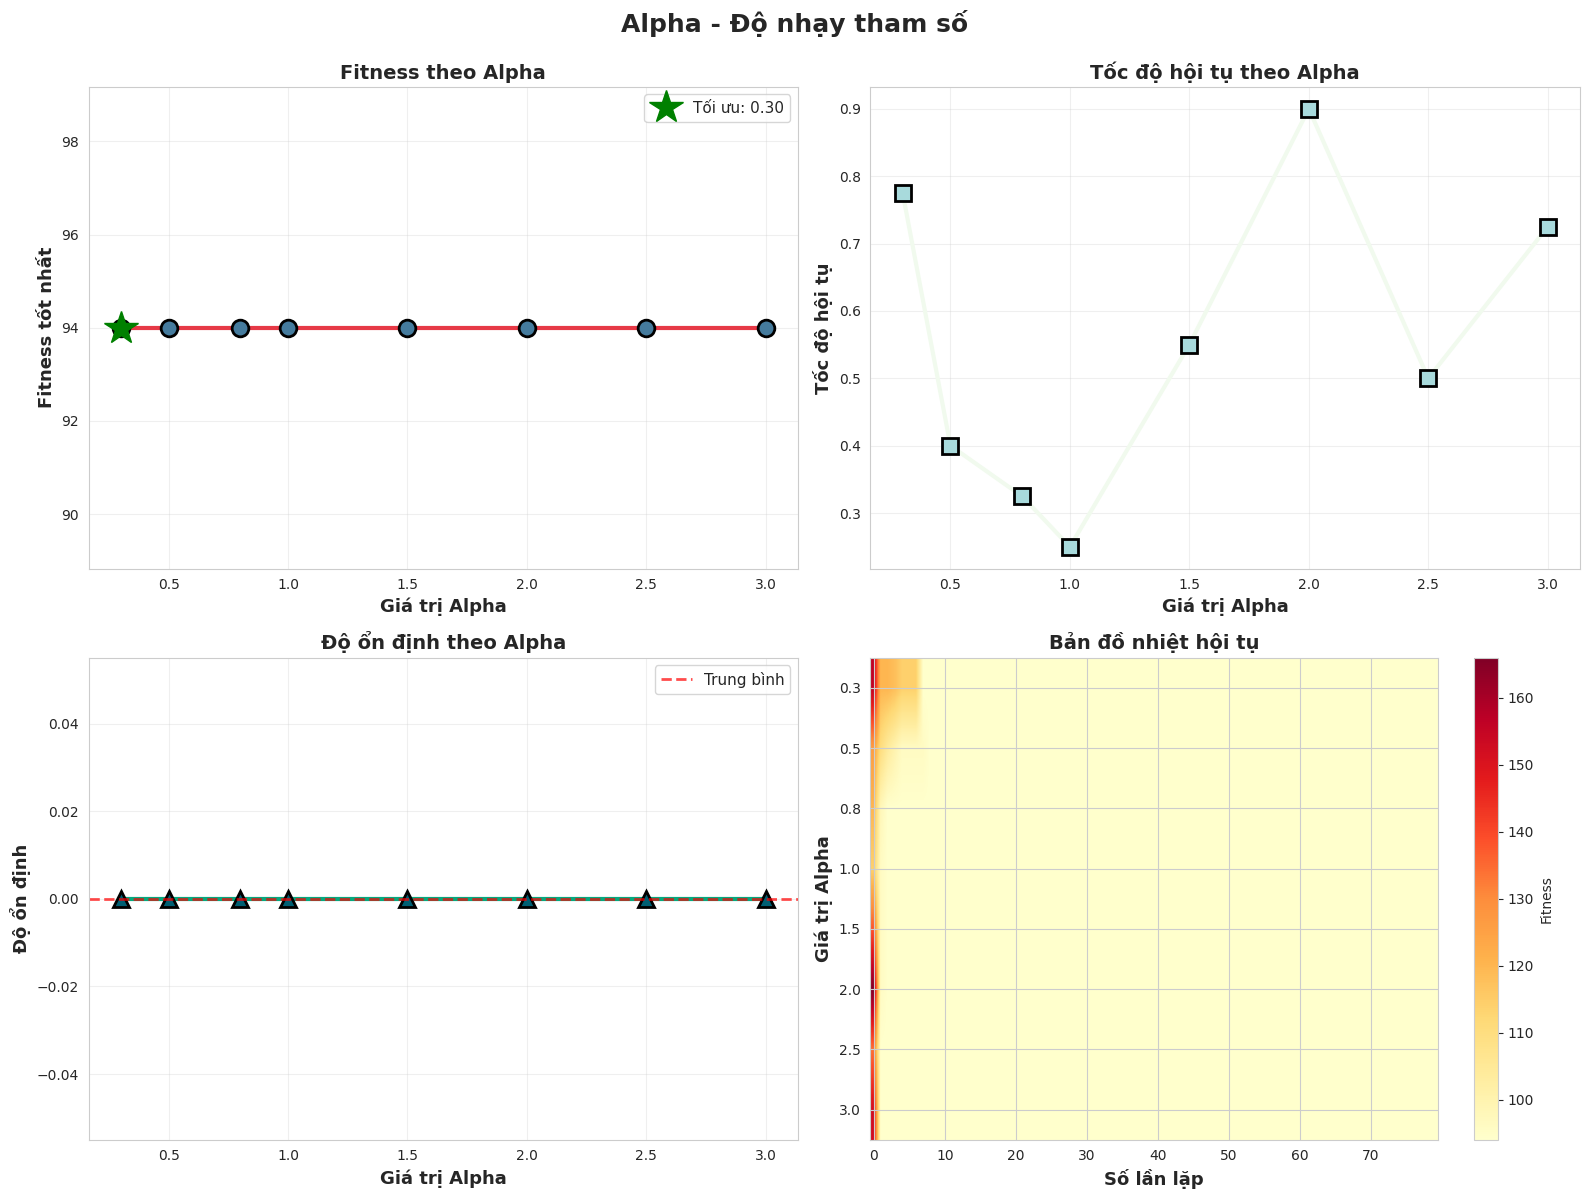


4. Bề mặt 3D - Tương tác Alpha x Beta


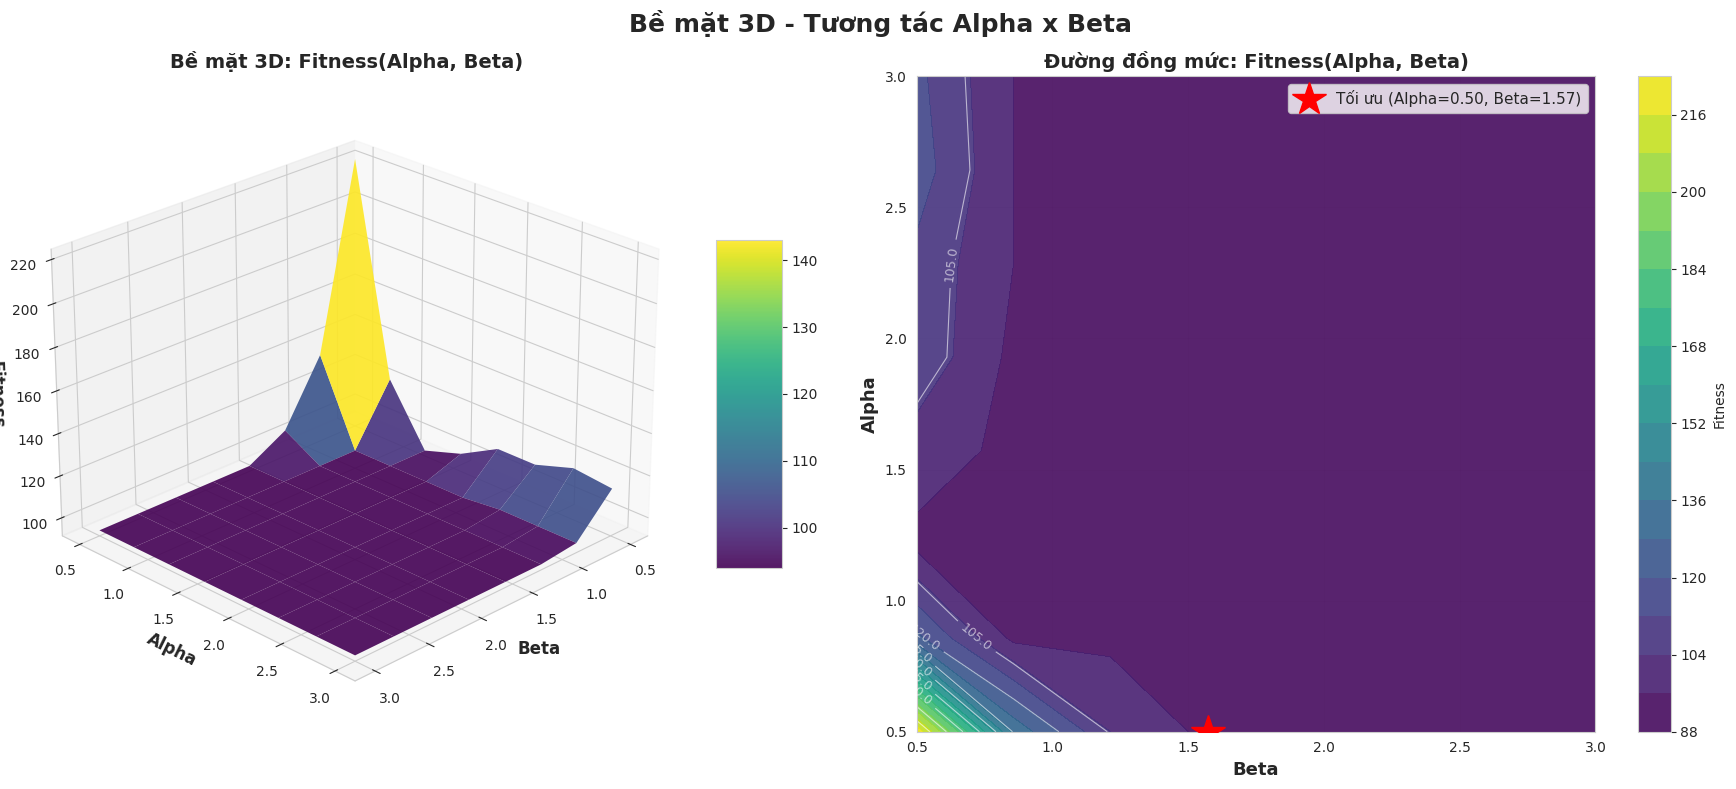

In [5]:
print("Bắt đầu phân tích ALPHA\n")

# Yêu cầu 1: Khả năng hội tụ
print("1. Phân tích khả năng hội tụ")
alpha_conv_configs = [
    {'alpha': 0.5, 'label': 'Alpha = 0.5 (Thấp)', 'short_label': 'α=0.5'},
    {'alpha': 1.0, 'label': 'Alpha = 1.0 (Trung bình)', 'short_label': 'α=1.0'},
    {'alpha': 2.0, 'label': 'Alpha = 2.0 (Cao)', 'short_label': 'α=2.0'},
    {'alpha': 3.0, 'label': 'Alpha = 3.0 (Rất cao)', 'short_label': 'α=3.0'}
]

alpha_conv_results = []
for cfg in alpha_conv_configs:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=cfg['alpha'], beta=2.0, rho=0.5, Q=100)
    _, best = aco.run()
    alpha_conv_results.append({
        'label': cfg['label'],
        'short_label': cfg['short_label'],
        'best_fitness': best,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })

plot_convergence(alpha_conv_results, 'ALPHA', 'alpha')

# Yêu cầu 2: So sánh hiệu suất
print("\n2. So sánh hiệu suất")
plot_comparative(alpha_conv_results, 'ALPHA', 'alpha')

# Yêu cầu 3: Độ nhạy tham số
print("\n3. Độ nhạy tham số")
alpha_values = [0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0]
alpha_sens_results = []
for alpha in alpha_values:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=80, alpha=alpha, beta=2.0, rho=0.5, Q=100)
    _, best = aco.run()
    alpha_sens_results.append({'best_fitness': best, 'history': aco.best_fitness_history})

plot_sensitivity(alpha_values, alpha_sens_results, 'Alpha', 'alpha')

# Yêu cầu 4: Bề mặt 3D
print("\n4. Bề mặt 3D - Tương tác Alpha x Beta")
alpha_range = np.linspace(0.5, 3.0, 8)
beta_range = np.linspace(0.5, 3.0, 8)
grid = np.zeros((len(alpha_range), len(beta_range)))
for i, a in enumerate(alpha_range):
    for j, b in enumerate(beta_range):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=60, alpha=a, beta=b, rho=0.5, Q=100)
        _, best = aco.run()
        grid[i, j] = best

plot_3d_surface(alpha_range, beta_range, grid, 'Alpha', 'Beta', 'alpha')



---
# PHẦN 2: PHÂN TÍCH THAM SỐ BETA

Beta điều khiển tầm quan trọng của thông tin heuristic (khoảng cách).
- Beta cao: Ưu tiên đường ngắn (tham lam)
- Beta thấp: Ít quan tâm đến khoảng cách

Bắt đầu phân tích BETA

1. Phân tích khả năng hội tụ


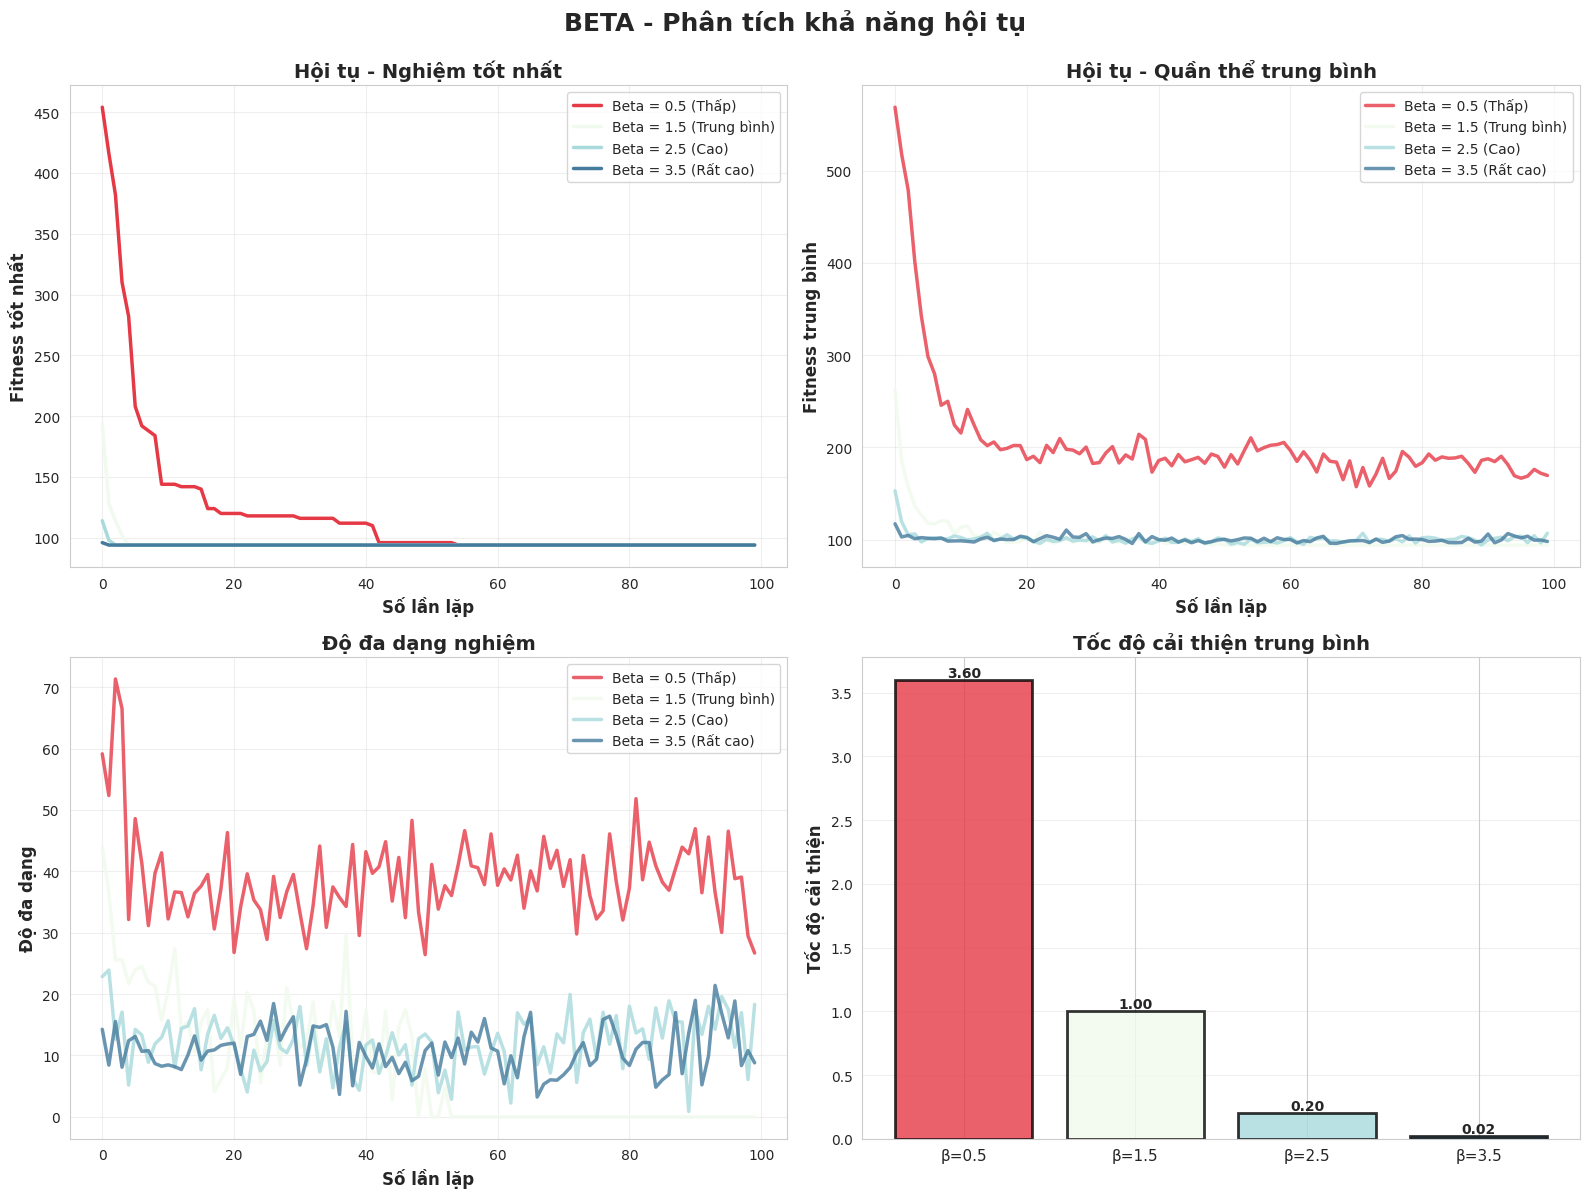


2. So sánh hiệu suất


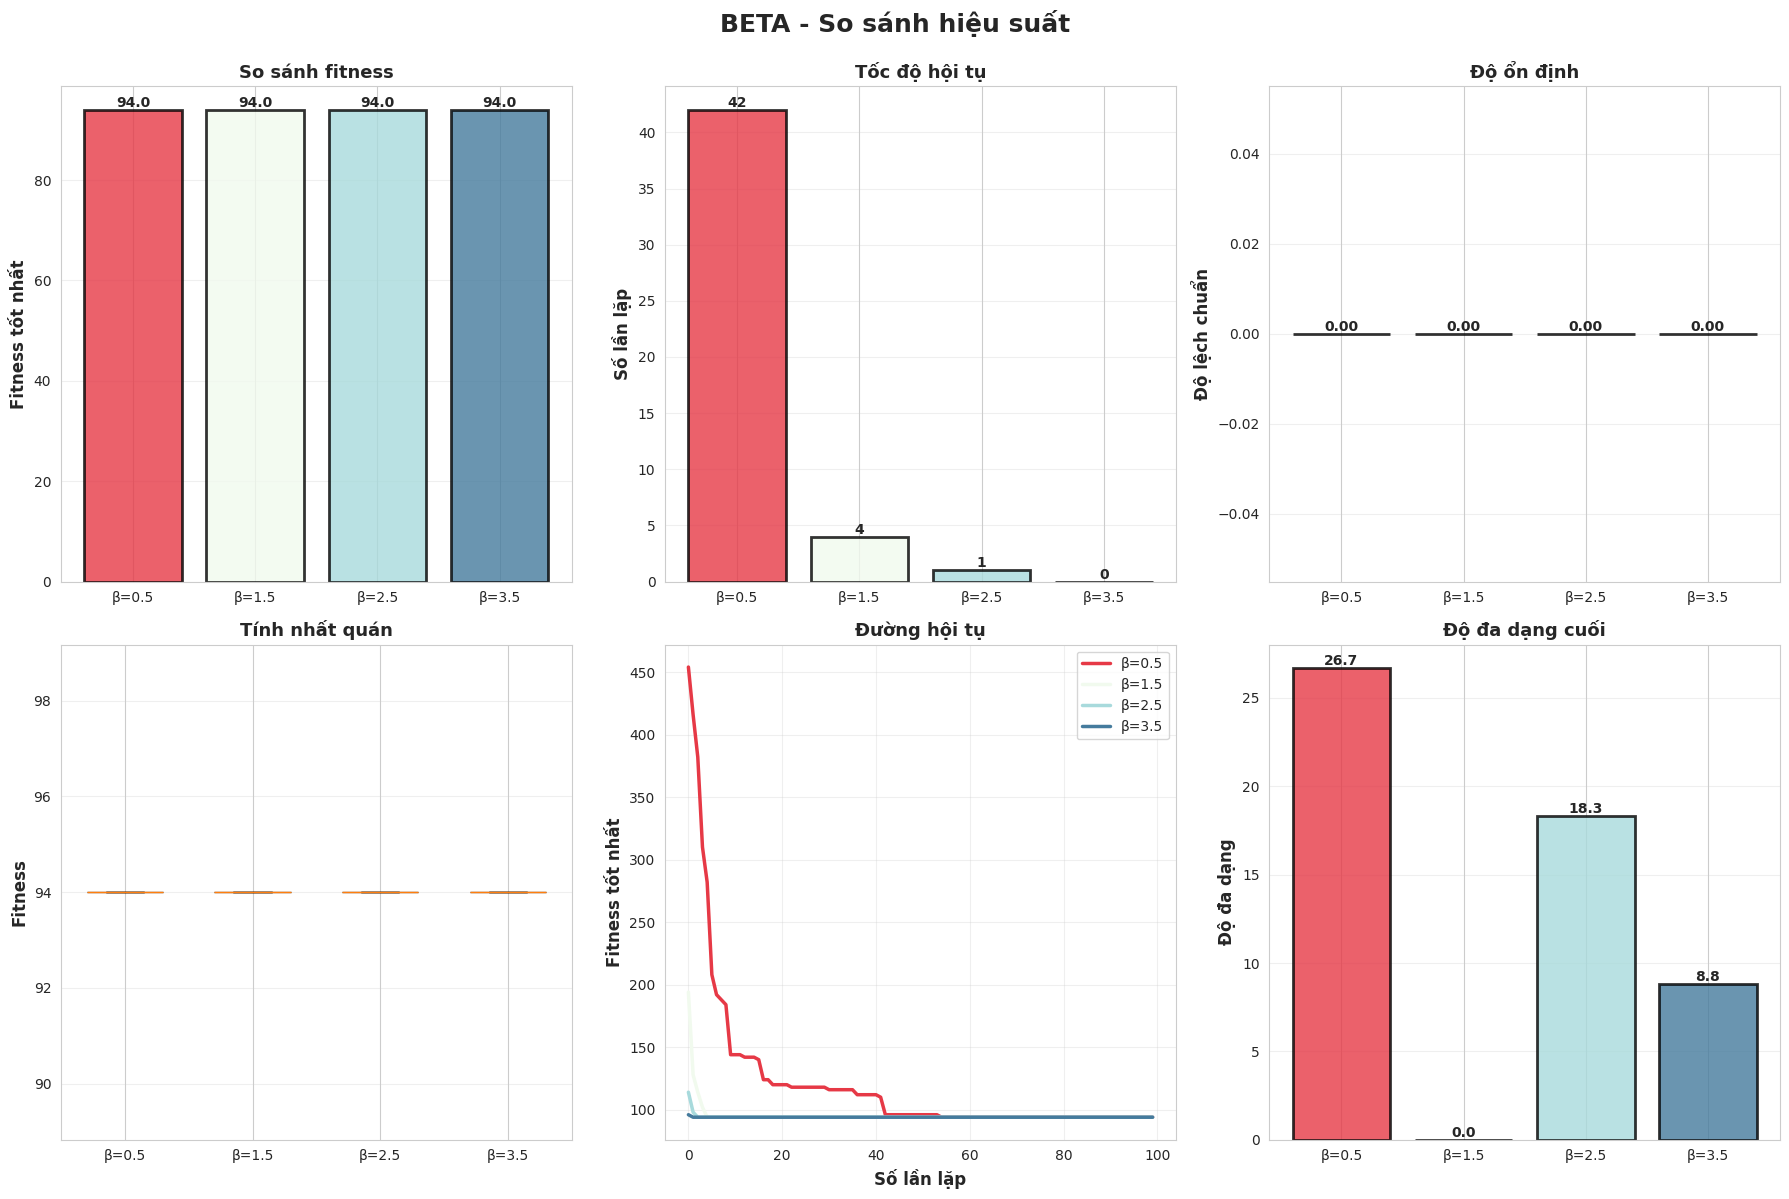


3. Độ nhạy tham số


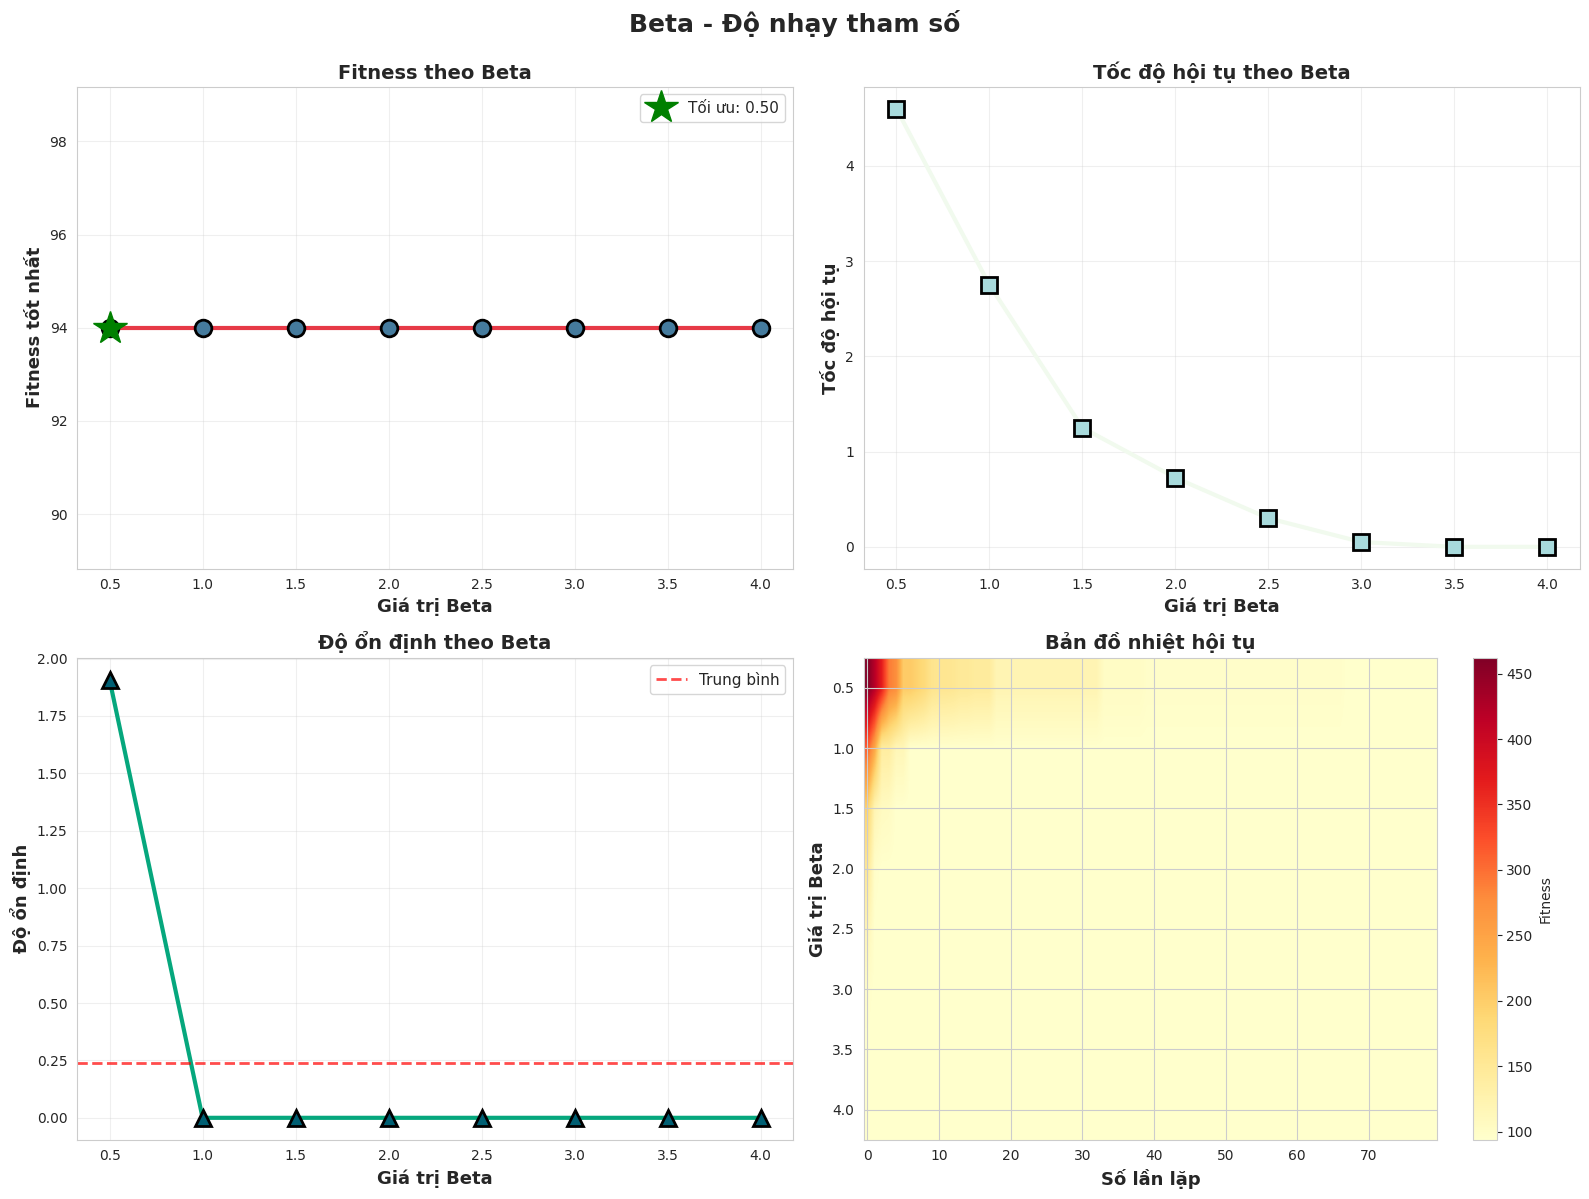


4. Bề mặt 3D - Tương tác Beta x Rho


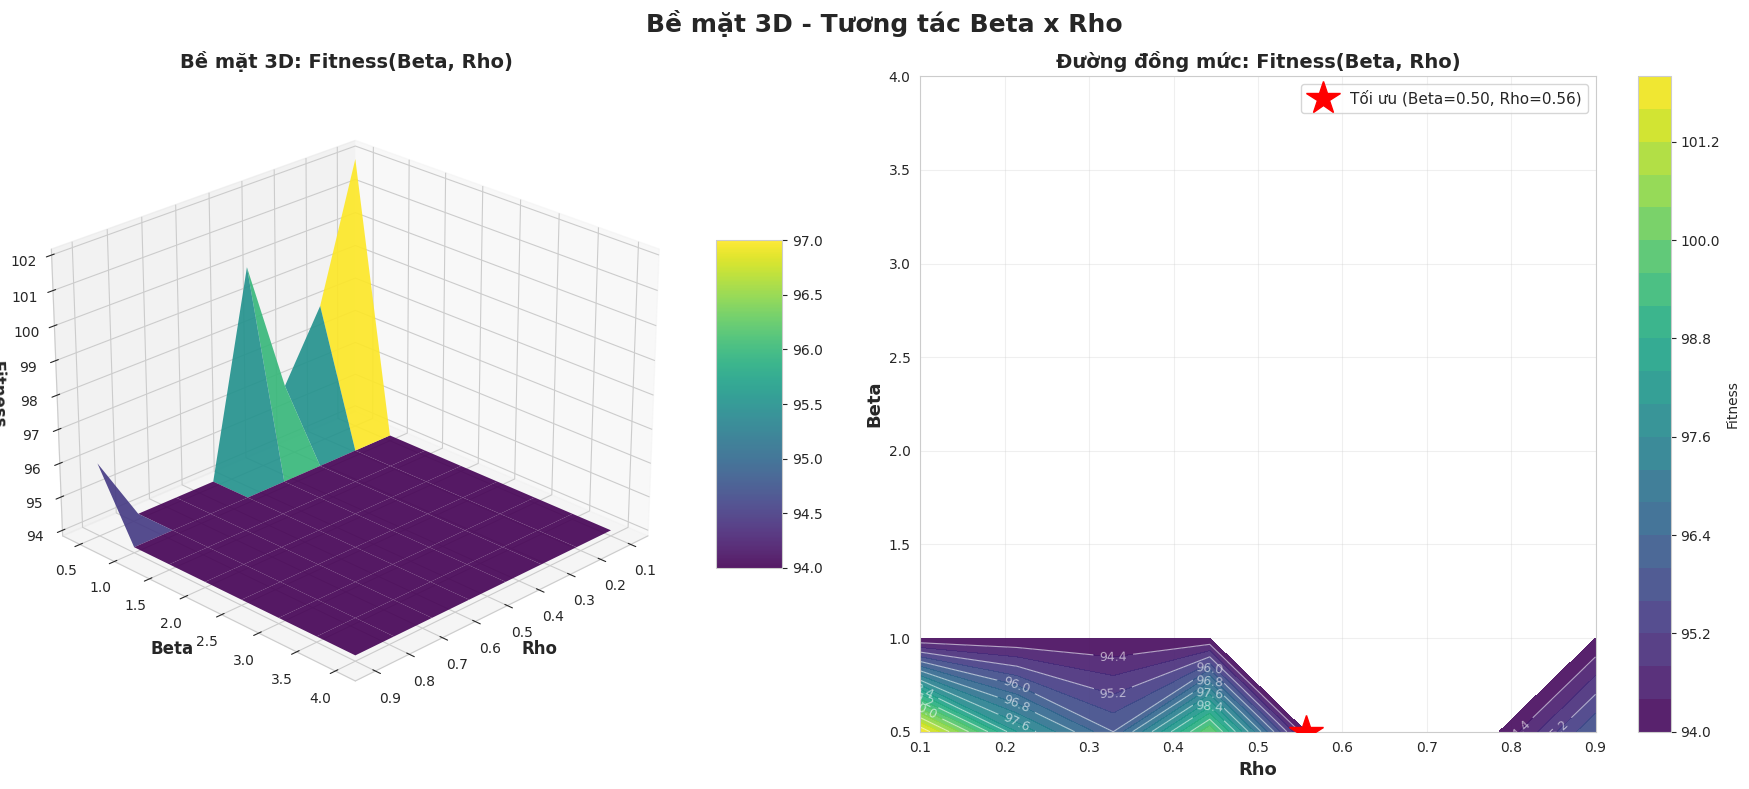

In [6]:
print("Bắt đầu phân tích BETA\n")

# Yêu cầu 1: Khả năng hội tụ
print("1. Phân tích khả năng hội tụ")
beta_conv_configs = [
    {'beta': 0.5, 'label': 'Beta = 0.5 (Thấp)', 'short_label': 'β=0.5'},
    {'beta': 1.5, 'label': 'Beta = 1.5 (Trung bình)', 'short_label': 'β=1.5'},
    {'beta': 2.5, 'label': 'Beta = 2.5 (Cao)', 'short_label': 'β=2.5'},
    {'beta': 3.5, 'label': 'Beta = 3.5 (Rất cao)', 'short_label': 'β=3.5'}
]

beta_conv_results = []
for cfg in beta_conv_configs:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=cfg['beta'], rho=0.5, Q=100)
    _, best = aco.run()
    beta_conv_results.append({
        'label': cfg['label'],
        'short_label': cfg['short_label'],
        'best_fitness': best,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })

plot_convergence(beta_conv_results, 'BETA', 'beta')

# Yêu cầu 2: So sánh hiệu suất
print("\n2. So sánh hiệu suất")
plot_comparative(beta_conv_results, 'BETA', 'beta')

# Yêu cầu 3: Độ nhạy tham số
print("\n3. Độ nhạy tham số")
beta_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
beta_sens_results = []
for beta in beta_values:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=80, alpha=1.0, beta=beta, rho=0.5, Q=100)
    _, best = aco.run()
    beta_sens_results.append({'best_fitness': best, 'history': aco.best_fitness_history})

plot_sensitivity(beta_values, beta_sens_results, 'Beta', 'beta')

# Yêu cầu 4: Bề mặt 3D
print("\n4. Bề mặt 3D - Tương tác Beta x Rho")
beta_range = np.linspace(0.5, 4.0, 8)
rho_range = np.linspace(0.1, 0.9, 8)
grid = np.zeros((len(beta_range), len(rho_range)))
for i, b in enumerate(beta_range):
    for j, r in enumerate(rho_range):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=60, alpha=1.0, beta=b, rho=r, Q=100)
        _, best = aco.run()
        grid[i, j] = best

plot_3d_surface(beta_range, rho_range, grid, 'Beta', 'Rho', 'beta')



---
# PHẦN 3: PHÂN TÍCH THAM SỐ RHO

Rho điều khiển tốc độ bay hơi của pheromone.
- Rho cao: Pheromone bay hơi nhanh (thăm dò)
- Rho thấp: Pheromone tồn tại lâu (khai thác)

Bắt đầu phân tích RHO

1. Phân tích khả năng hội tụ


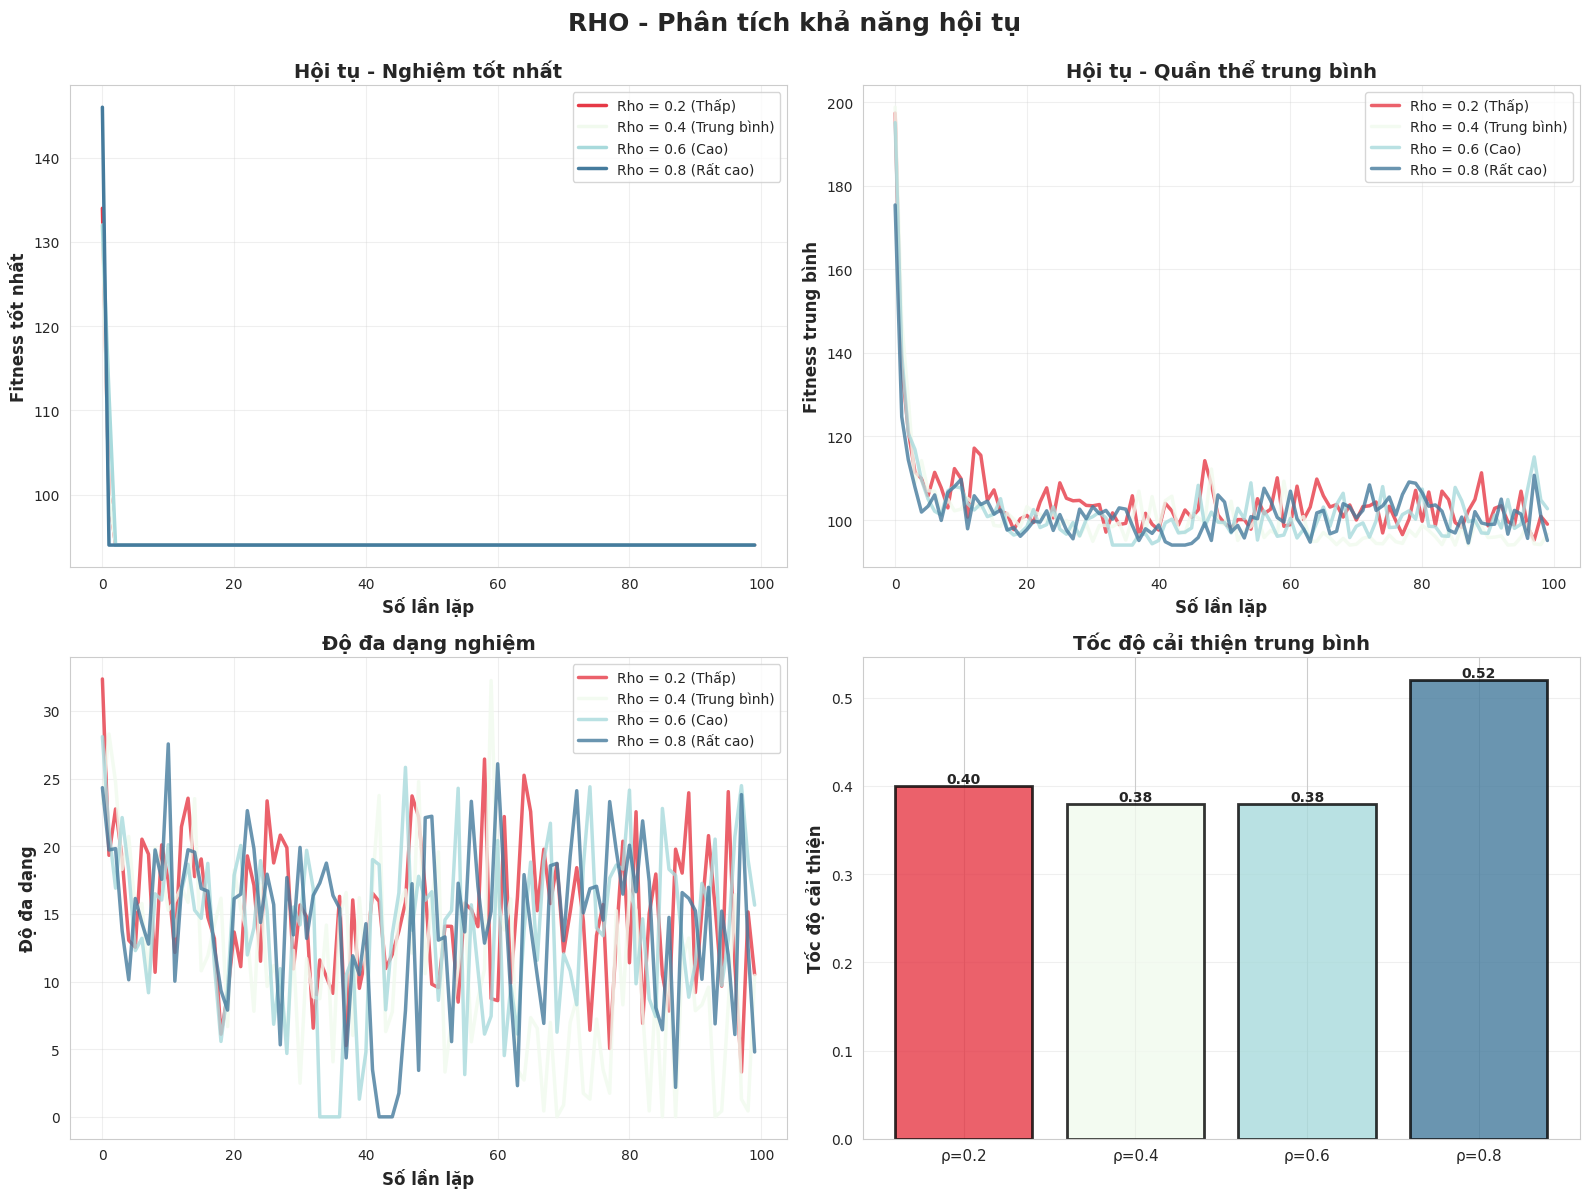


2. So sánh hiệu suất


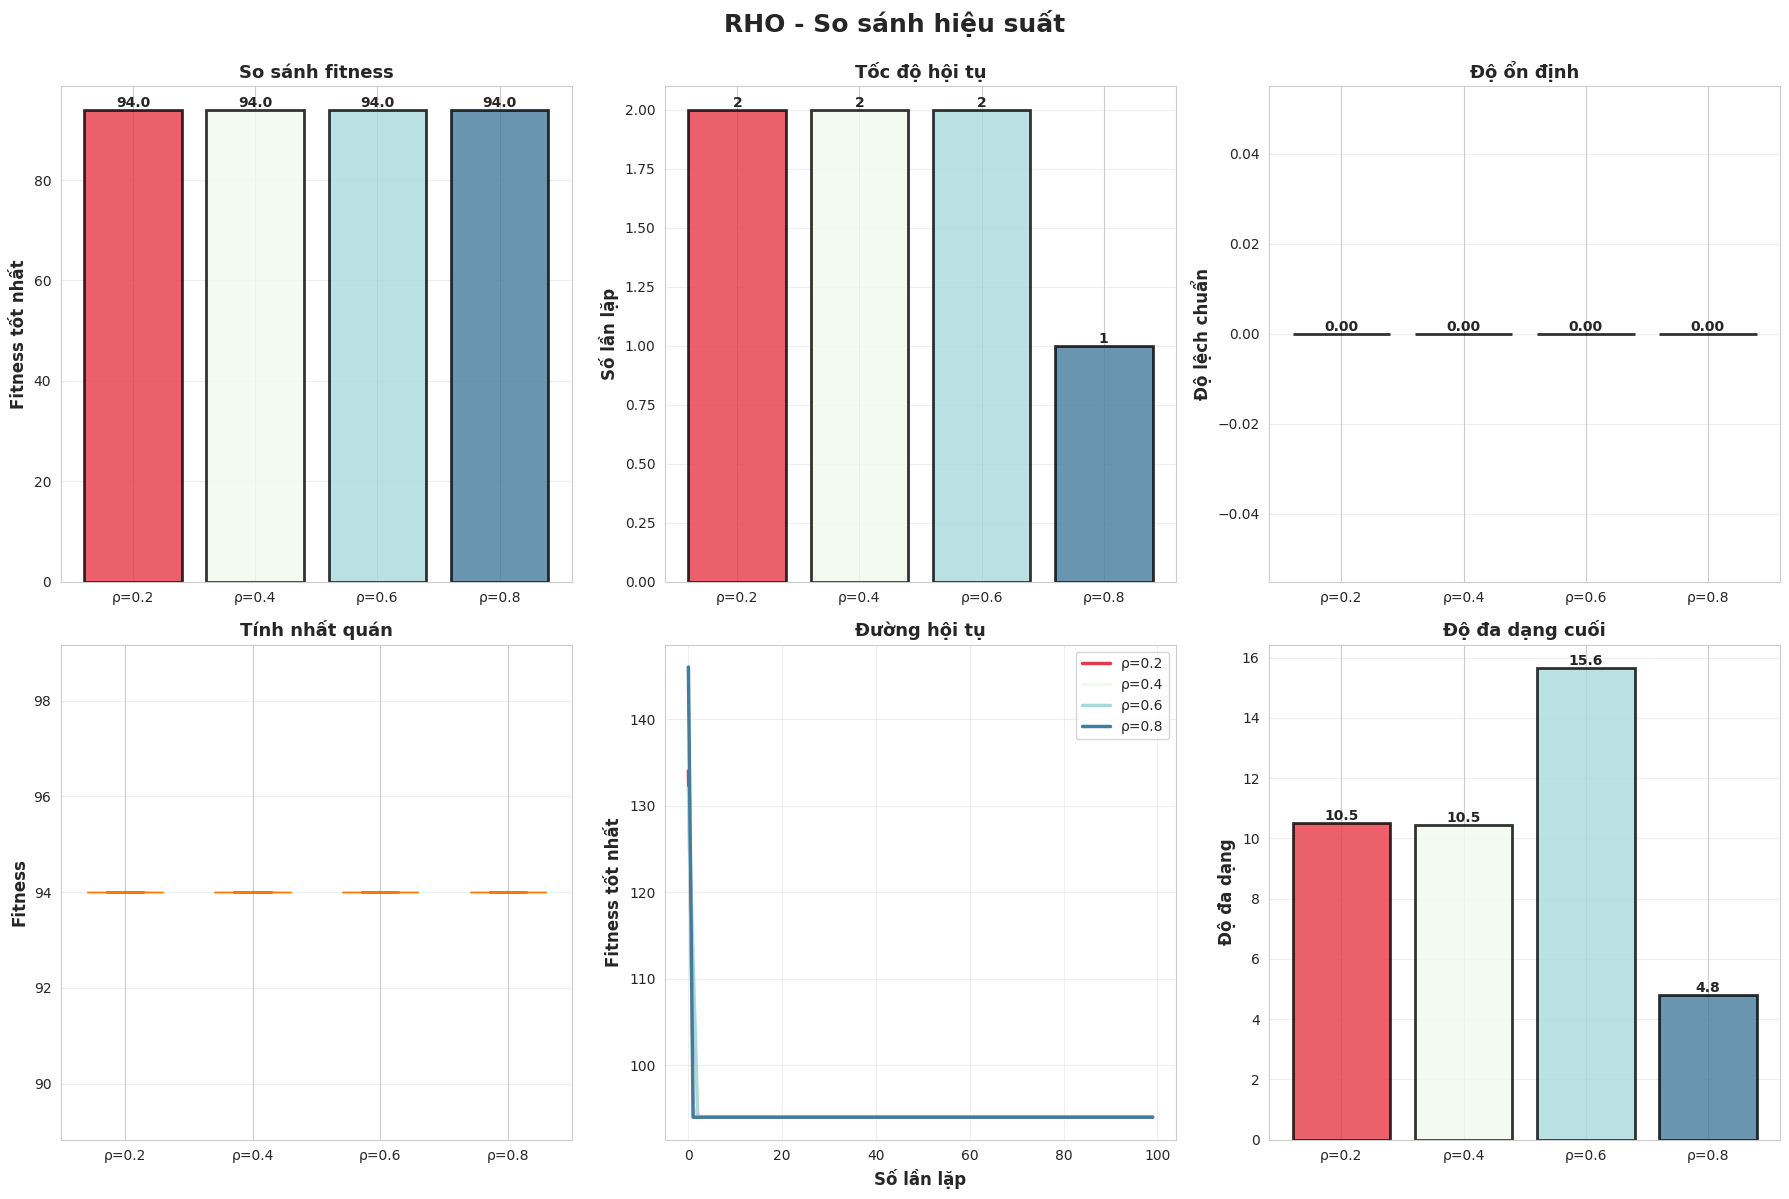


3. Độ nhạy tham số


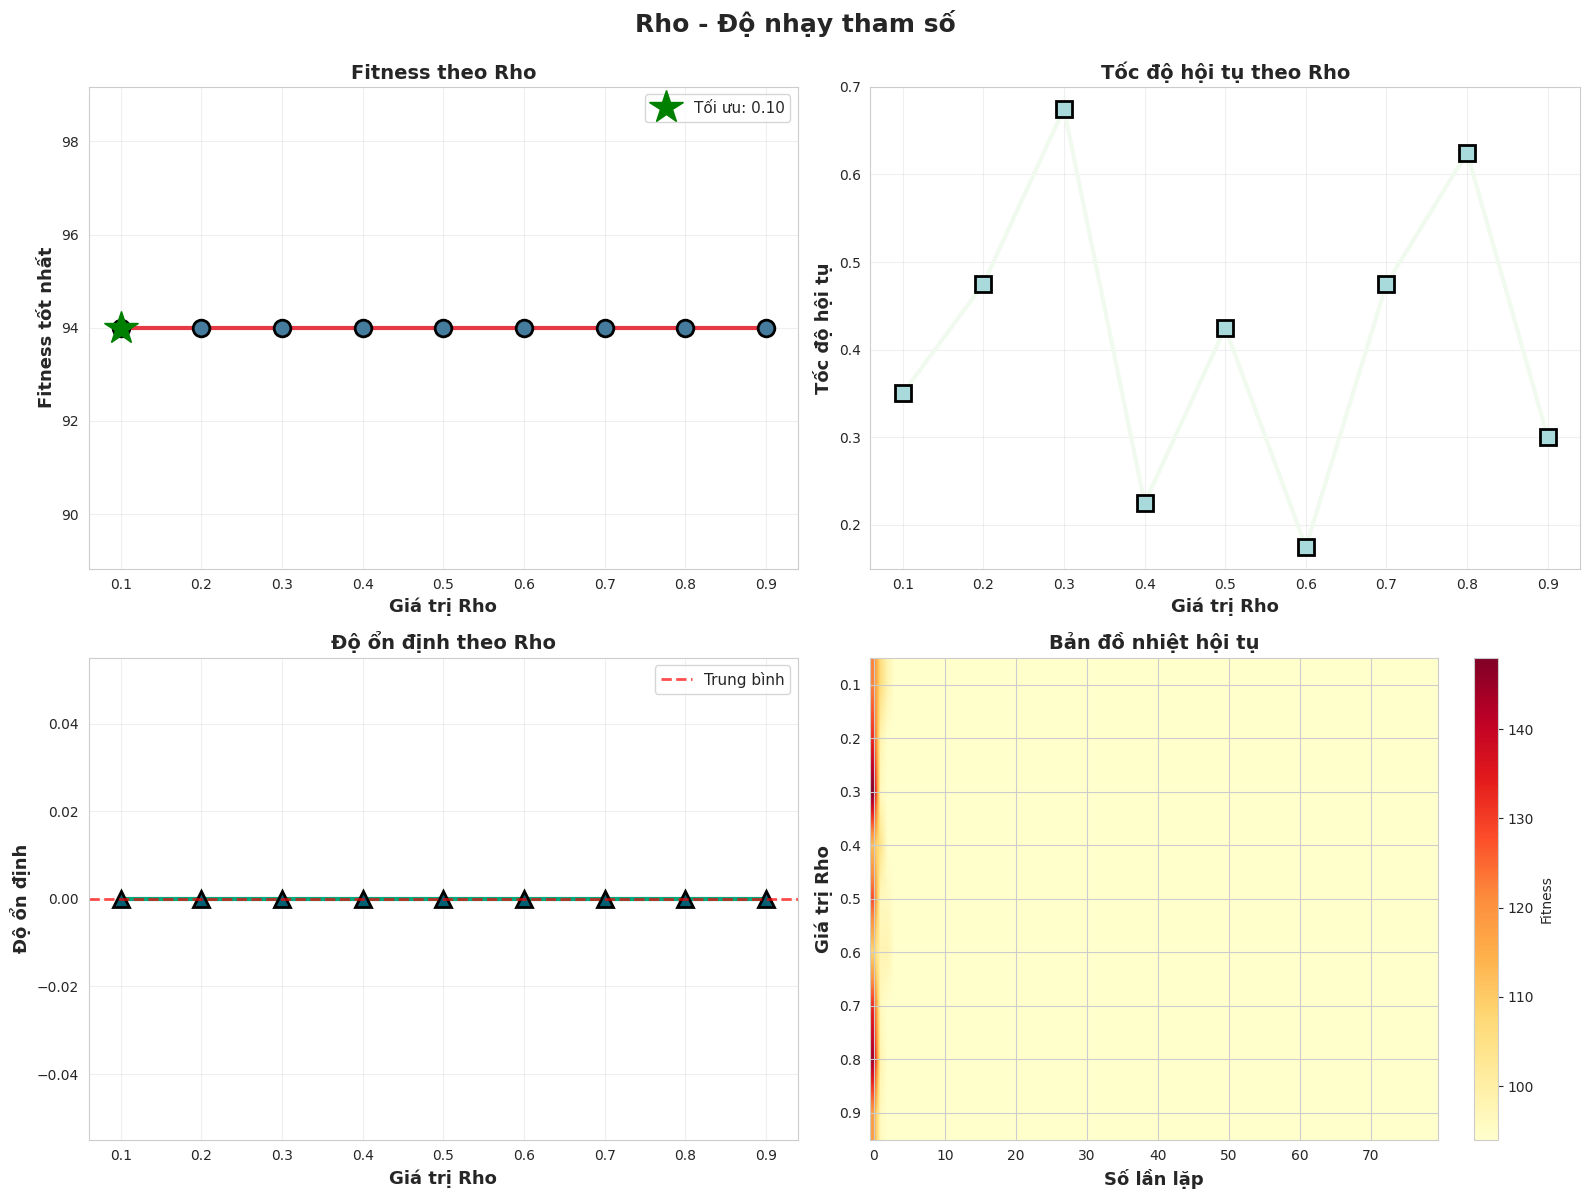


4. Bề mặt 3D - Tương tác Rho x Alpha


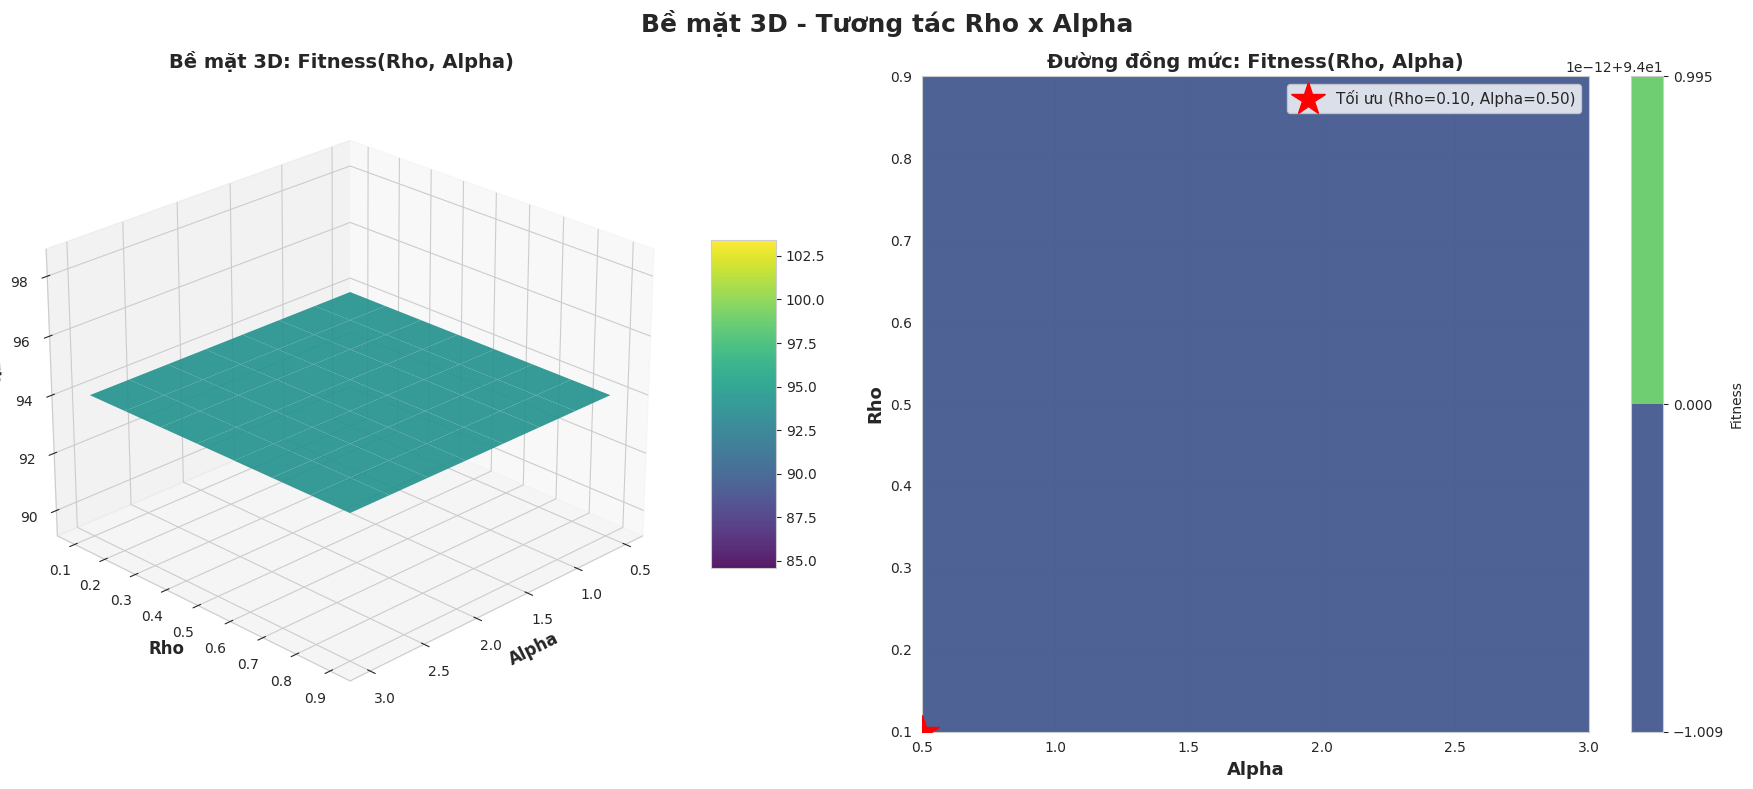

In [7]:
print("Bắt đầu phân tích RHO\n")

# Yêu cầu 1: Khả năng hội tụ
print("1. Phân tích khả năng hội tụ")
rho_conv_configs = [
    {'rho': 0.2, 'label': 'Rho = 0.2 (Thấp)', 'short_label': 'ρ=0.2'},
    {'rho': 0.4, 'label': 'Rho = 0.4 (Trung bình)', 'short_label': 'ρ=0.4'},
    {'rho': 0.6, 'label': 'Rho = 0.6 (Cao)', 'short_label': 'ρ=0.6'},
    {'rho': 0.8, 'label': 'Rho = 0.8 (Rất cao)', 'short_label': 'ρ=0.8'}
]

rho_conv_results = []
for cfg in rho_conv_configs:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=2.0, rho=cfg['rho'], Q=100)
    _, best = aco.run()
    rho_conv_results.append({
        'label': cfg['label'],
        'short_label': cfg['short_label'],
        'best_fitness': best,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })

plot_convergence(rho_conv_results, 'RHO', 'rho')

# Yêu cầu 2: So sánh hiệu suất
print("\n2. So sánh hiệu suất")
plot_comparative(rho_conv_results, 'RHO', 'rho')

# Yêu cầu 3: Độ nhạy tham số
print("\n3. Độ nhạy tham số")
rho_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rho_sens_results = []
for rho in rho_values:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=80, alpha=1.0, beta=2.0, rho=rho, Q=100)
    _, best = aco.run()
    rho_sens_results.append({'best_fitness': best, 'history': aco.best_fitness_history})

plot_sensitivity(rho_values, rho_sens_results, 'Rho', 'rho')

# Yêu cầu 4: Bề mặt 3D
print("\n4. Bề mặt 3D - Tương tác Rho x Alpha")
rho_range = np.linspace(0.1, 0.9, 8)
alpha_range = np.linspace(0.5, 3.0, 8)
grid = np.zeros((len(rho_range), len(alpha_range)))
for i, r in enumerate(rho_range):
    for j, a in enumerate(alpha_range):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=60, alpha=a, beta=2.0, rho=r, Q=100)
        _, best = aco.run()
        grid[i, j] = best

plot_3d_surface(rho_range, alpha_range, grid, 'Rho', 'Alpha', 'rho')



---
# PHẦN 4: PHÂN TÍCH SỐ LƯỢNG KIẾN

Số lượng kiến ảnh hưởng đến khả năng thăm dò không gian nghiệm.
- Nhiều kiến: Thăm dò tốt hơn, chi phí tính toán cao
- Ít kiến: Nhanh hơn nhưng có thể bỏ lỡ nghiệm tốt

Bắt đầu phân tích SỐ LƯỢNG KIẾN

1. Phân tích khả năng hội tụ


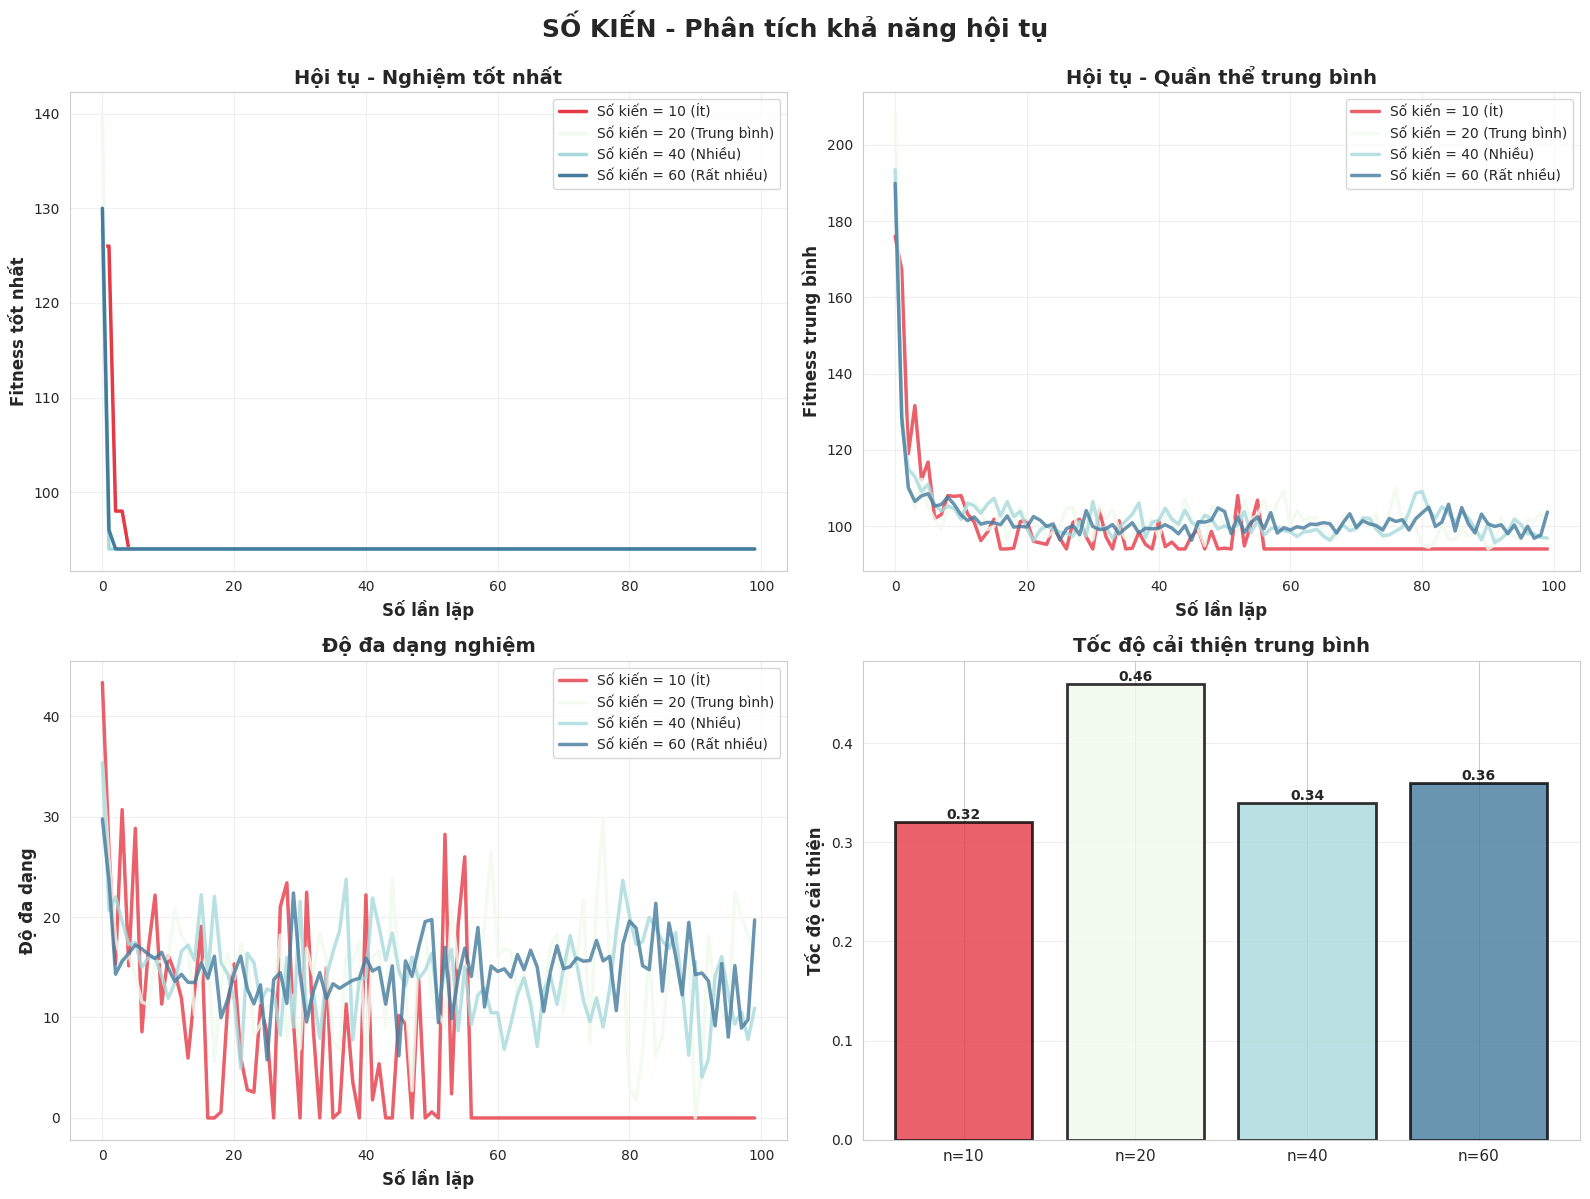


2. So sánh hiệu suất


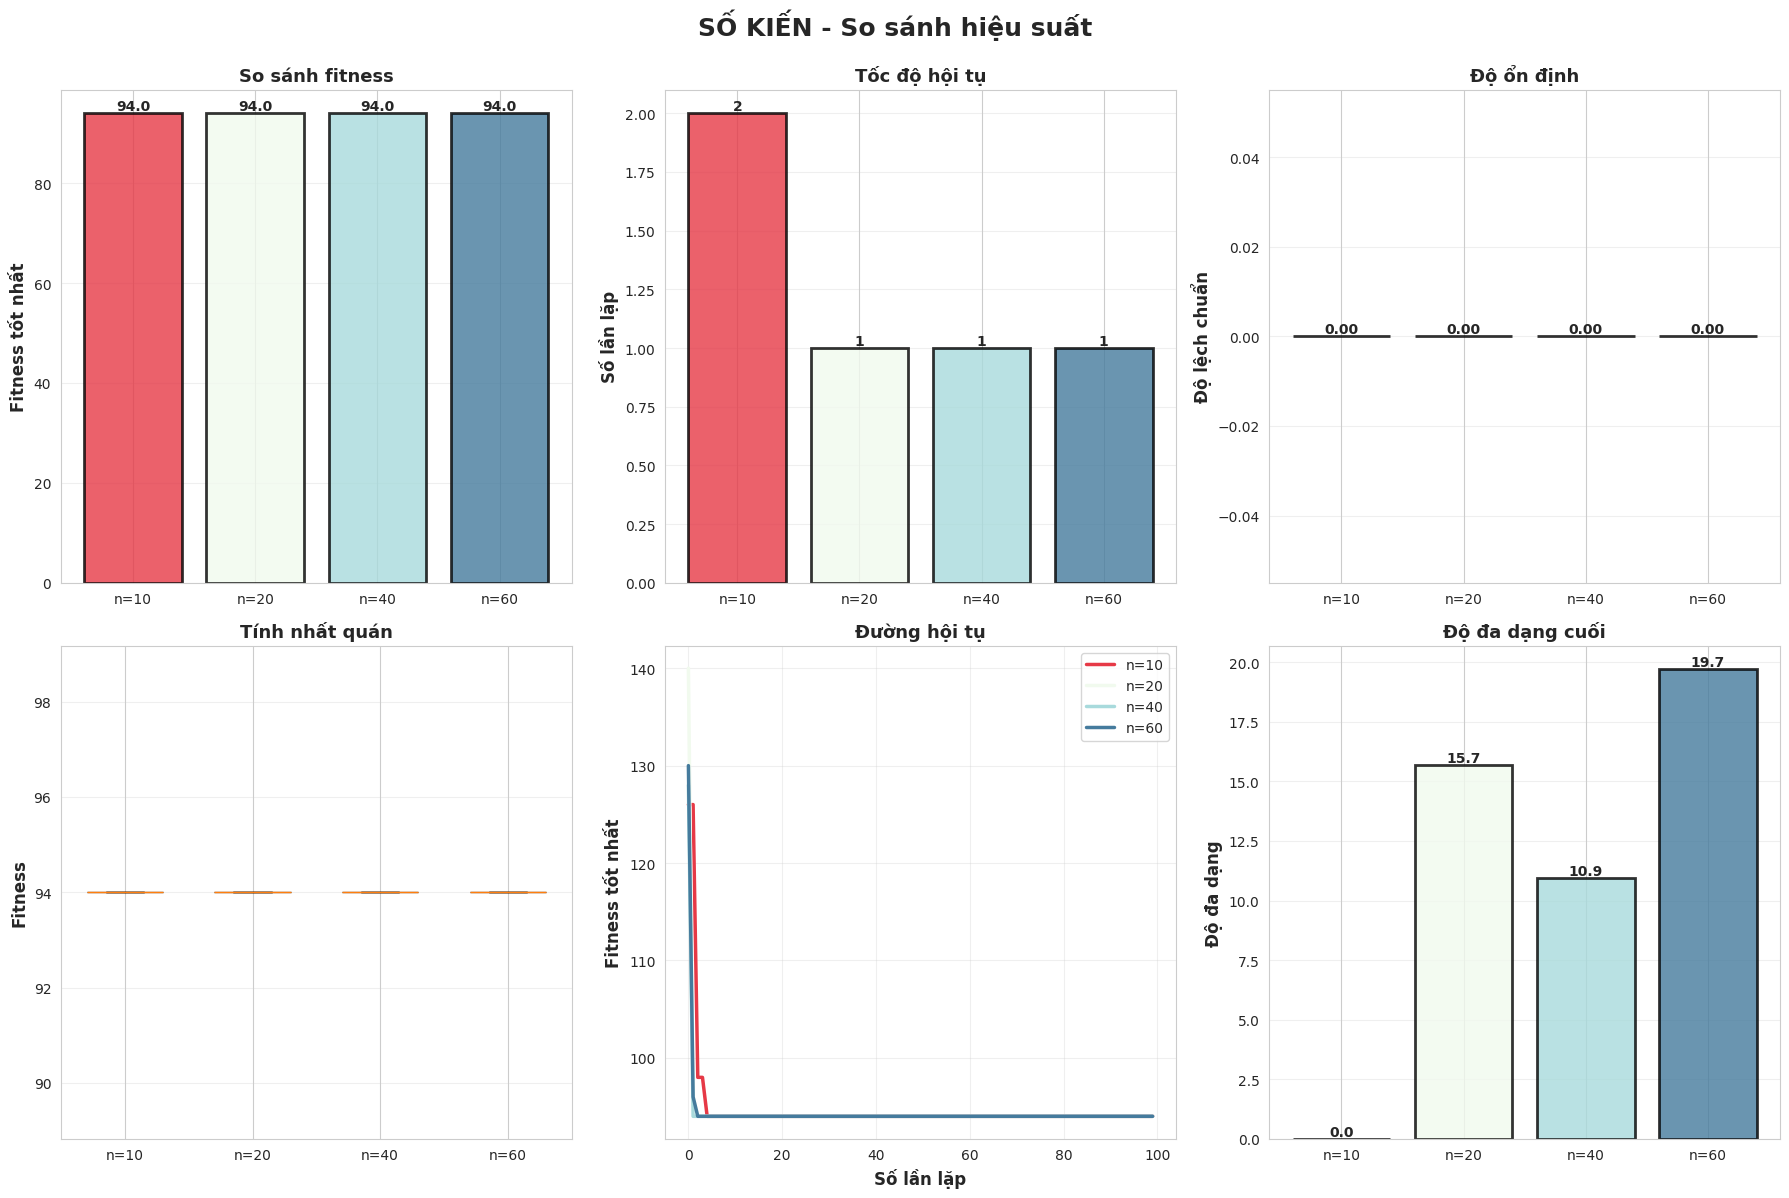


3. Độ nhạy tham số


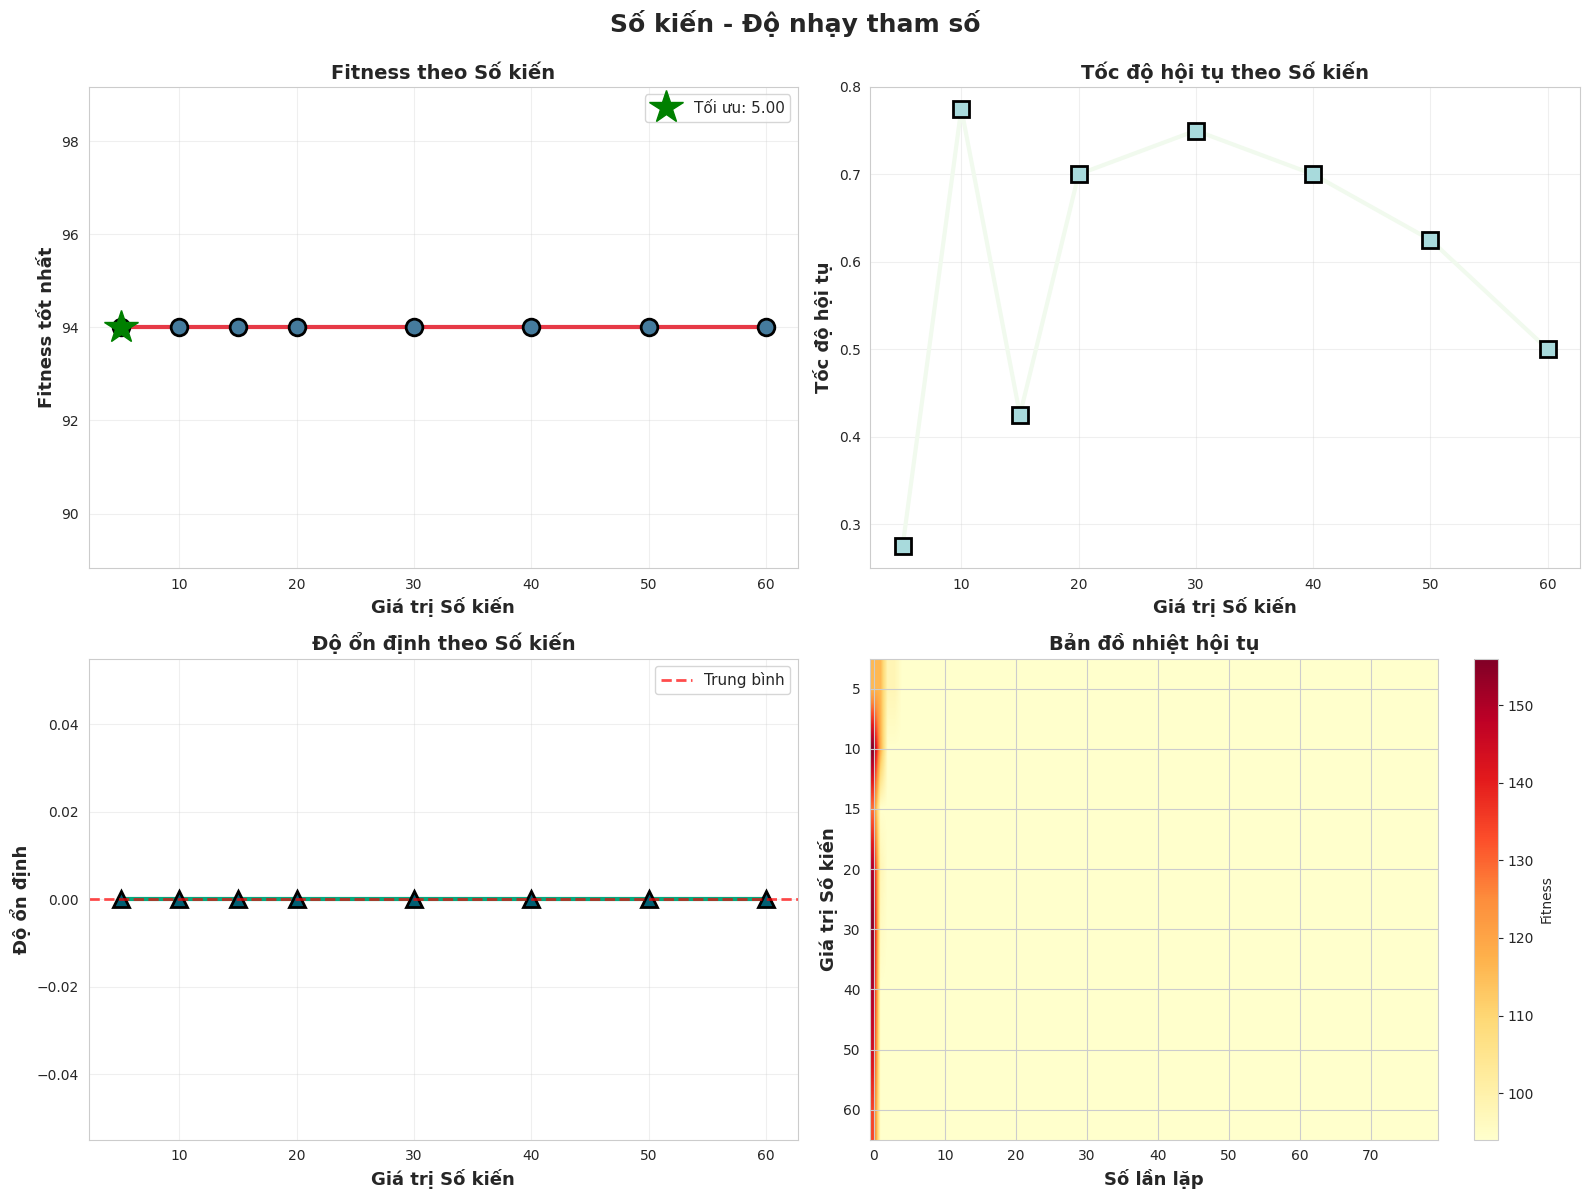


4. Bề mặt 3D - Tương tác Số kiến x Alpha


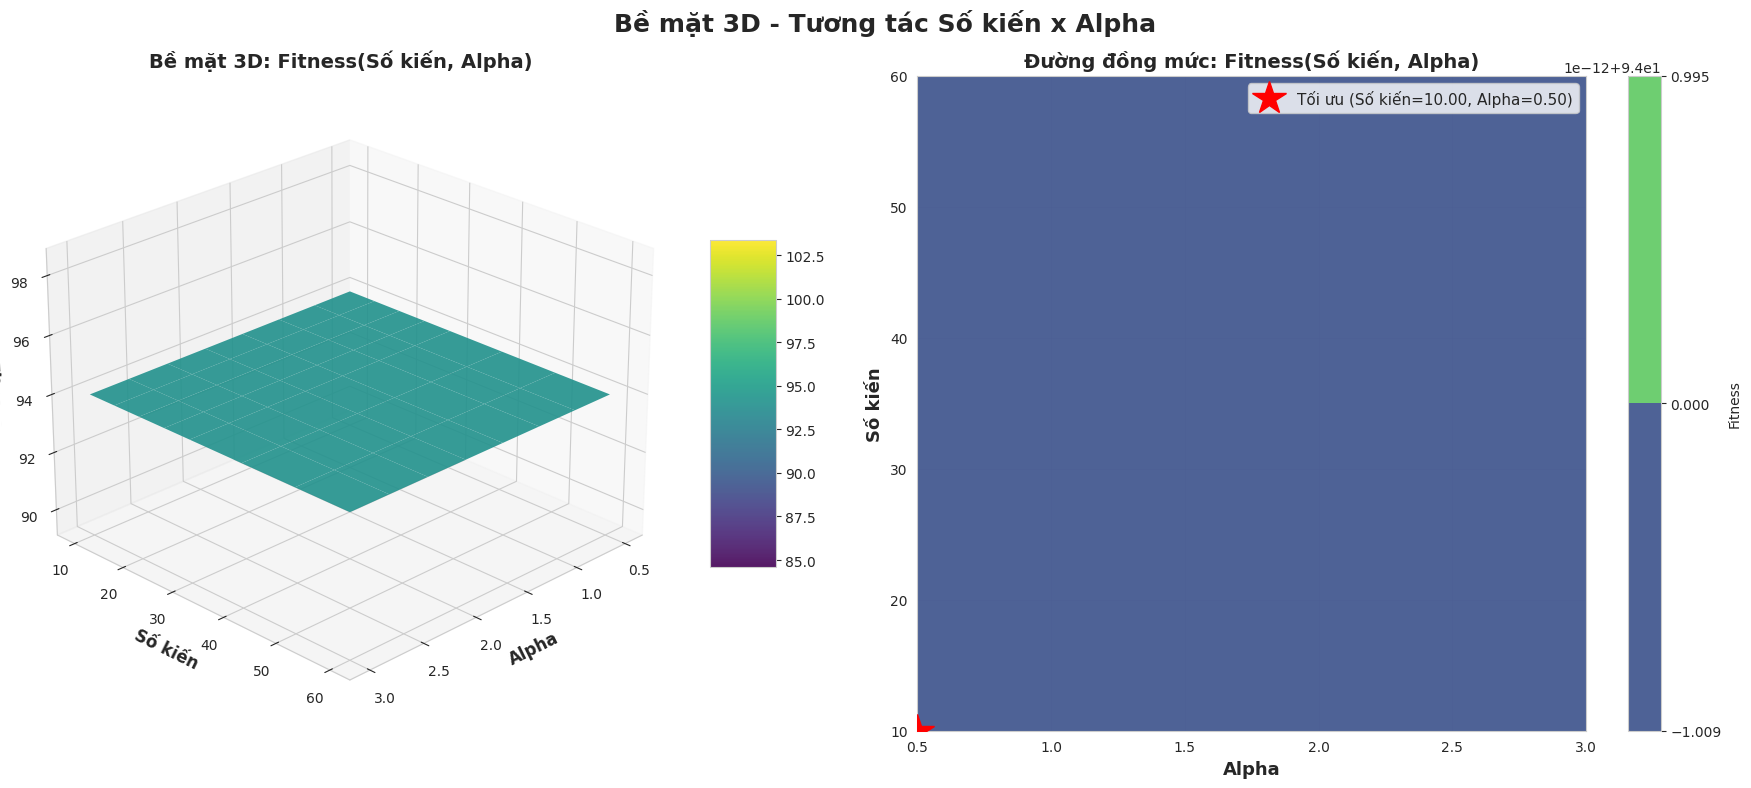

In [8]:
print("Bắt đầu phân tích SỐ LƯỢNG KIẾN\n")

# Yêu cầu 1: Khả năng hội tụ
print("1. Phân tích khả năng hội tụ")
ant_conv_configs = [
    {'num_ant': 10, 'label': 'Số kiến = 10 (Ít)', 'short_label': 'n=10'},
    {'num_ant': 20, 'label': 'Số kiến = 20 (Trung bình)', 'short_label': 'n=20'},
    {'num_ant': 40, 'label': 'Số kiến = 40 (Nhiều)', 'short_label': 'n=40'},
    {'num_ant': 60, 'label': 'Số kiến = 60 (Rất nhiều)', 'short_label': 'n=60'}
]

ant_conv_results = []
for cfg in ant_conv_configs:
    aco = AntColonyOptimizer(cities, num_ant=cfg['num_ant'], iter=100, alpha=1.0, beta=2.0, rho=0.5, Q=100)
    _, best = aco.run()
    ant_conv_results.append({
        'label': cfg['label'],
        'short_label': cfg['short_label'],
        'best_fitness': best,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })

plot_convergence(ant_conv_results, 'SỐ KIẾN', 'so_kien')

# Yêu cầu 2: So sánh hiệu suất
print("\n2. So sánh hiệu suất")
plot_comparative(ant_conv_results, 'SỐ KIẾN', 'so_kien')

# Yêu cầu 3: Độ nhạy tham số
print("\n3. Độ nhạy tham số")
ant_values = [5, 10, 15, 20, 30, 40, 50, 60]
ant_sens_results = []
for num_ant in ant_values:
    aco = AntColonyOptimizer(cities, num_ant=num_ant, iter=80, alpha=1.0, beta=2.0, rho=0.5, Q=100)
    _, best = aco.run()
    ant_sens_results.append({'best_fitness': best, 'history': aco.best_fitness_history})

plot_sensitivity(ant_values, ant_sens_results, 'Số kiến', 'so_kien')

# Yêu cầu 4: Bề mặt 3D
print("\n4. Bề mặt 3D - Tương tác Số kiến x Alpha")
ant_range = np.array([10, 15, 20, 25, 30, 40, 50, 60])
alpha_range = np.linspace(0.5, 3.0, 8)
grid = np.zeros((len(ant_range), len(alpha_range)))
for i, n in enumerate(ant_range):
    for j, a in enumerate(alpha_range):
        aco = AntColonyOptimizer(cities, num_ant=n, iter=60, alpha=a, beta=2.0, rho=0.5, Q=100)
        _, best = aco.run()
        grid[i, j] = best

plot_3d_surface(ant_range, alpha_range, grid, 'Số kiến', 'Alpha', 'so_kien')



---
# PHẦN 5: PHÂN TÍCH THAM SỐ Q

Q là hằng số điều khiển lượng pheromone được thêm vào.
- Q cao: Thêm nhiều pheromone (tăng cường khai thác)
- Q thấp: Thêm ít pheromone (giảm ảnh hưởng pheromone)

Bắt đầu phân tích THAM SỐ Q

1. Phân tích khả năng hội tụ


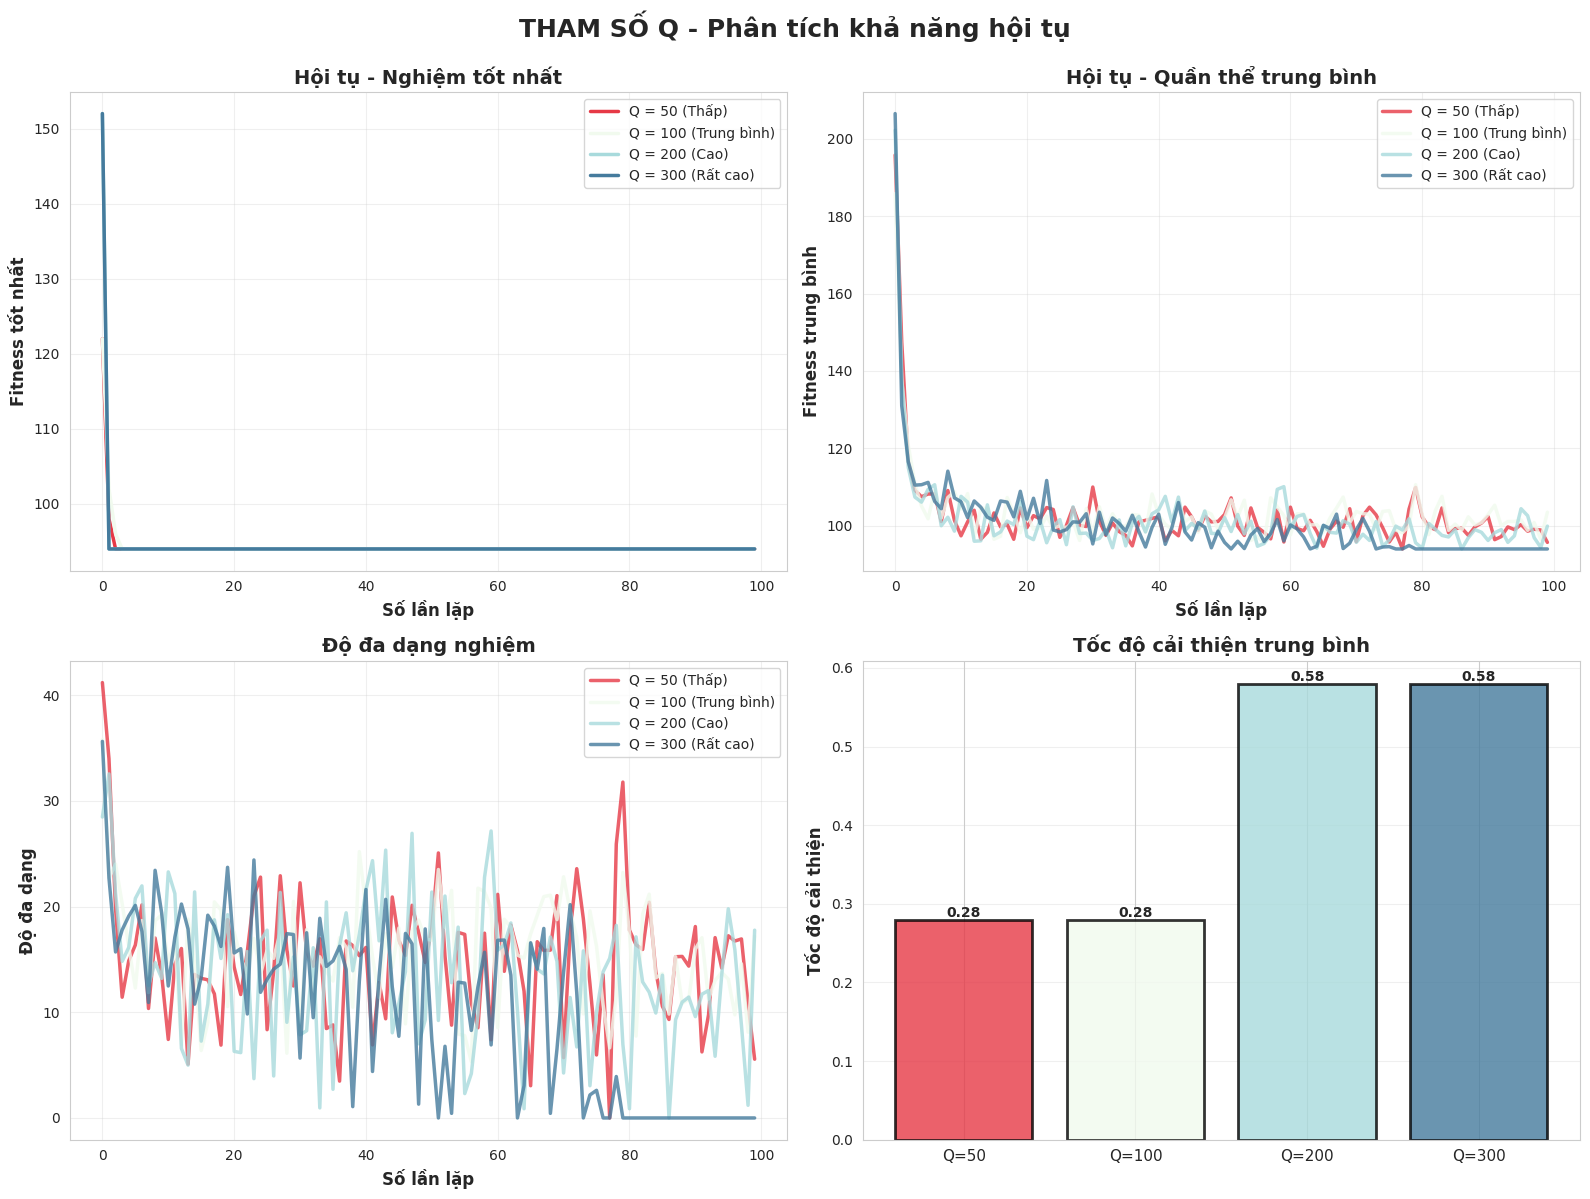


2. So sánh hiệu suất


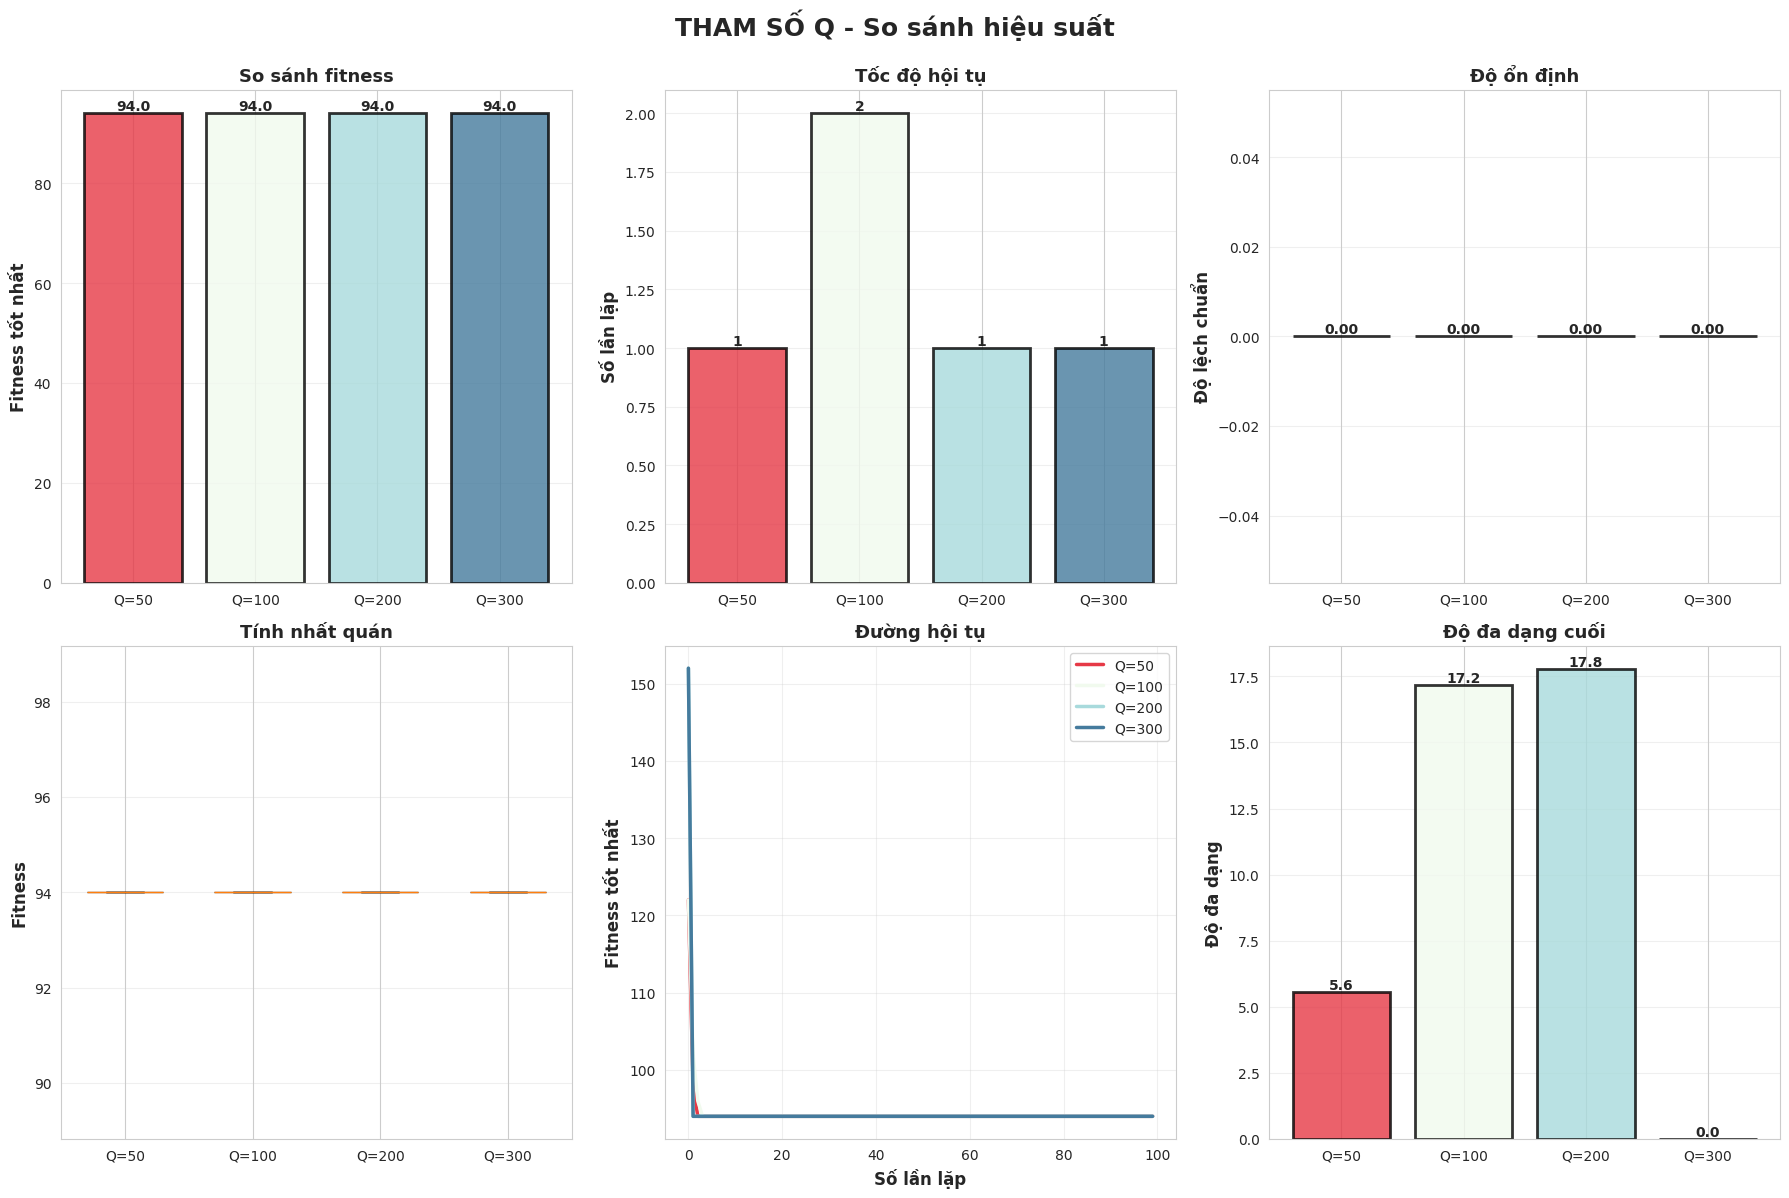


3. Độ nhạy tham số


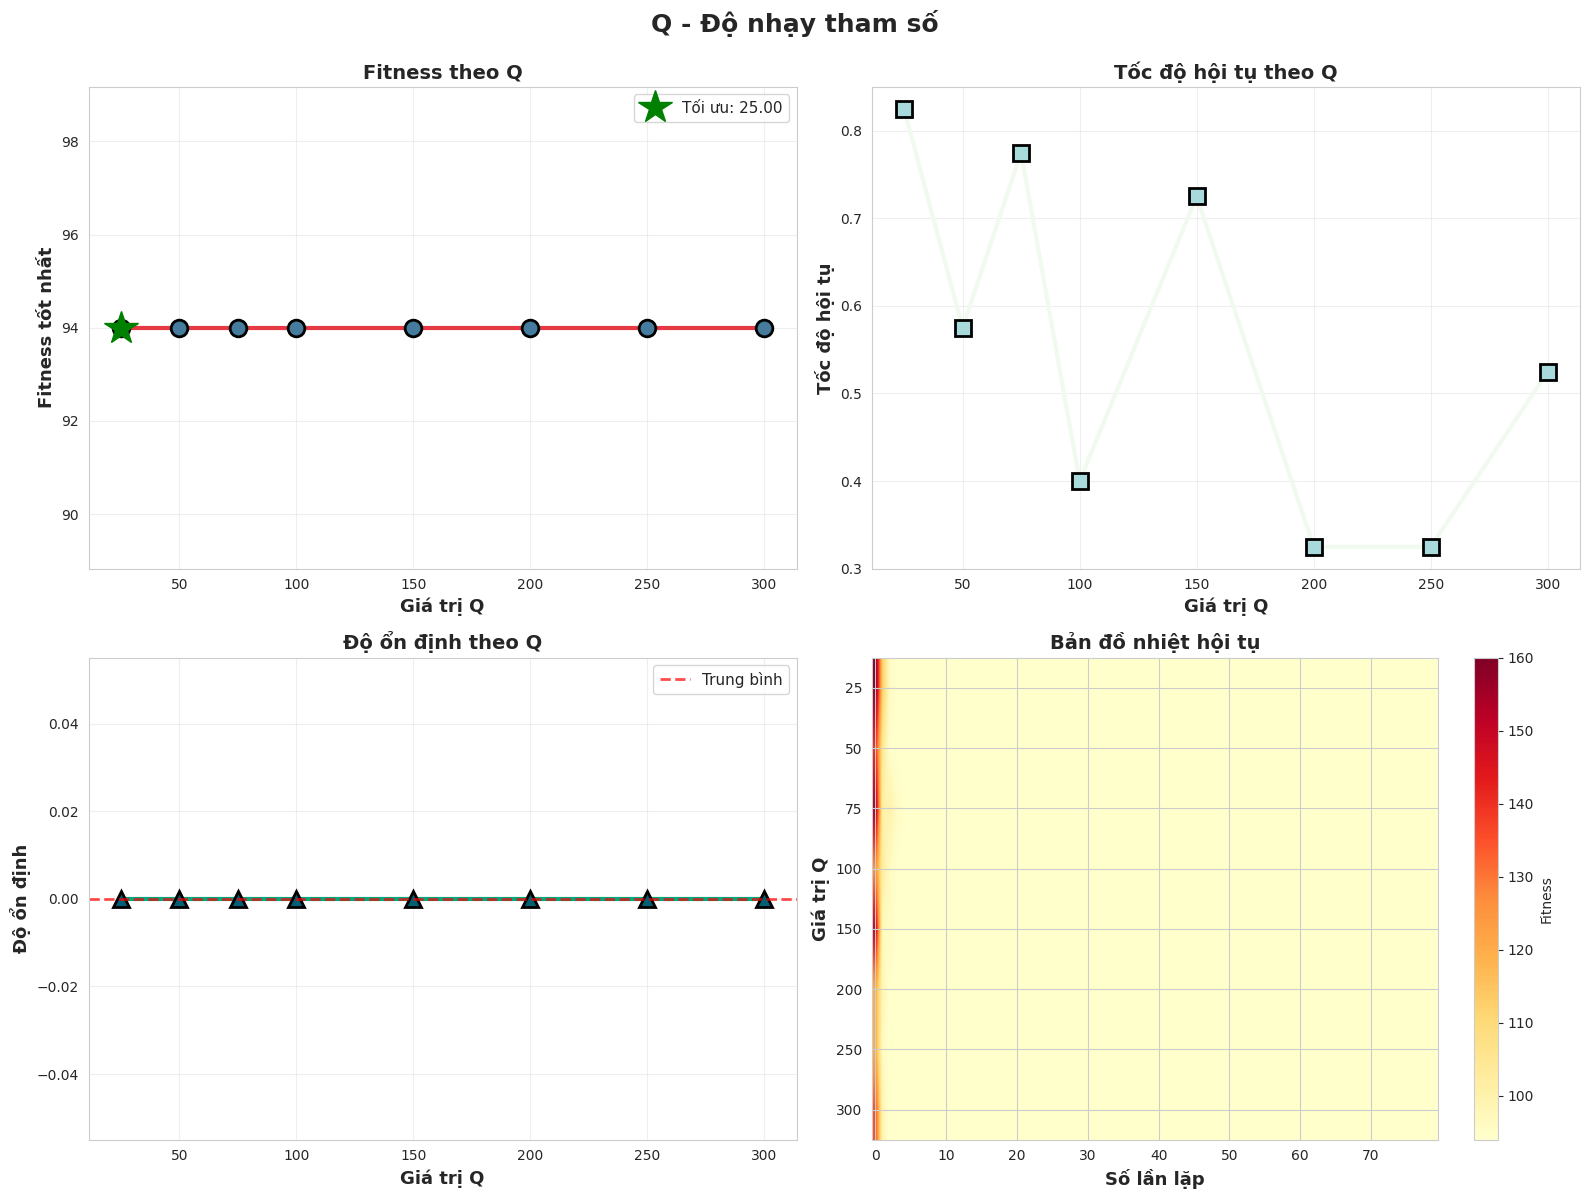


4. Bề mặt 3D - Tương tác Q x Rho


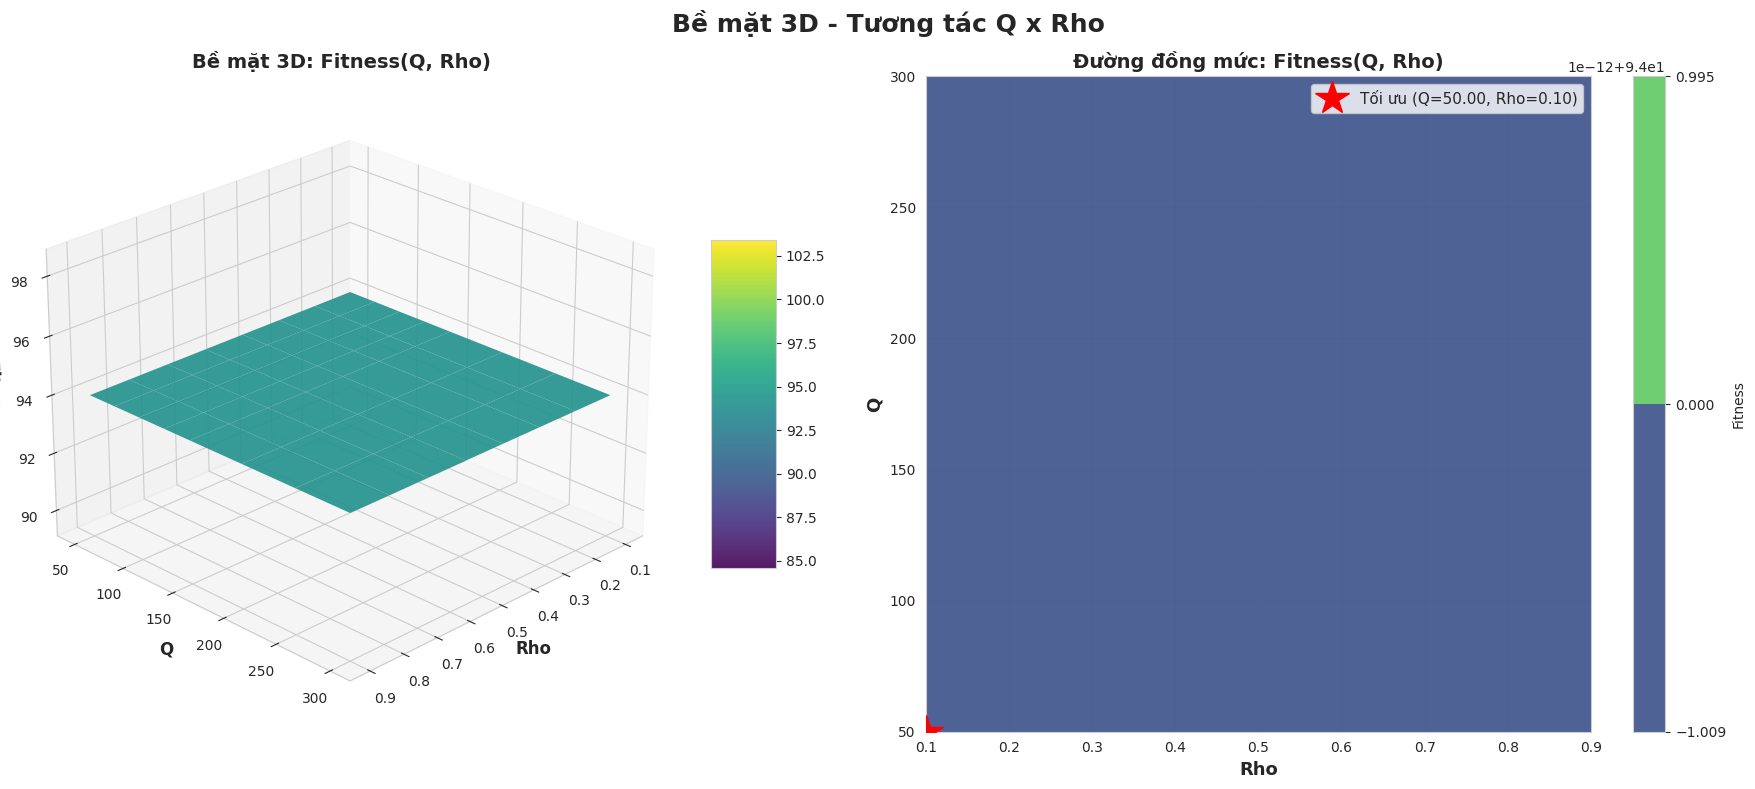

In [9]:
print("Bắt đầu phân tích THAM SỐ Q\n")

# Yêu cầu 1: Khả năng hội tụ
print("1. Phân tích khả năng hội tụ")
q_conv_configs = [
    {'Q': 50, 'label': 'Q = 50 (Thấp)', 'short_label': 'Q=50'},
    {'Q': 100, 'label': 'Q = 100 (Trung bình)', 'short_label': 'Q=100'},
    {'Q': 200, 'label': 'Q = 200 (Cao)', 'short_label': 'Q=200'},
    {'Q': 300, 'label': 'Q = 300 (Rất cao)', 'short_label': 'Q=300'}
]

q_conv_results = []
for cfg in q_conv_configs:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=100, alpha=1.0, beta=2.0, rho=0.5, Q=cfg['Q'])
    _, best = aco.run()
    q_conv_results.append({
        'label': cfg['label'],
        'short_label': cfg['short_label'],
        'best_fitness': best,
        'best_history': aco.best_fitness_history,
        'avg_history': aco.avg_fitness_history,
        'diversity': aco.diversity_history
    })

plot_convergence(q_conv_results, 'THAM SỐ Q', 'tham_so_q')

# Yêu cầu 2: So sánh hiệu suất
print("\n2. So sánh hiệu suất")
plot_comparative(q_conv_results, 'THAM SỐ Q', 'tham_so_q')

# Yêu cầu 3: Độ nhạy tham số
print("\n3. Độ nhạy tham số")
q_values = [25, 50, 75, 100, 150, 200, 250, 300]
q_sens_results = []
for q in q_values:
    aco = AntColonyOptimizer(cities, num_ant=20, iter=80, alpha=1.0, beta=2.0, rho=0.5, Q=q)
    _, best = aco.run()
    q_sens_results.append({'best_fitness': best, 'history': aco.best_fitness_history})

plot_sensitivity(q_values, q_sens_results, 'Q', 'tham_so_q')

# Yêu cầu 4: Bề mặt 3D
print("\n4. Bề mặt 3D - Tương tác Q x Rho")
q_range = np.array([50, 75, 100, 125, 150, 200, 250, 300])
rho_range = np.linspace(0.1, 0.9, 8)
grid = np.zeros((len(q_range), len(rho_range)))
for i, q in enumerate(q_range):
    for j, r in enumerate(rho_range):
        aco = AntColonyOptimizer(cities, num_ant=20, iter=60, alpha=1.0, beta=2.0, rho=r, Q=q)
        _, best = aco.run()
        grid[i, j] = best

plot_3d_surface(q_range, rho_range, grid, 'Q', 'Rho', 'tham_so_q')



## Kết quả chính

### 1. Alpha (Tầm quan trọng pheromone)
- Khoảng tối ưu: 1.0 - 2.0
- Alpha thấp: Thăm dò cao, hội tụ chậm
- Alpha cao: Hội tụ nhanh, dễ tối ưu cục bộ

### 2. Beta (Tầm quan trọng heuristic)
- Khoảng tối ưu: 2.0 - 3.0
- Beta thấp: Ít tham lam, khám phá nhiều
- Beta cao: Rất tham lam, ưu tiên đường ngắn

### 3. Rho (Tốc độ bay hơi)
- Khoảng tối ưu: 0.3 - 0.7
- Rho thấp: Pheromone tồn tại lâu
- Rho cao: Bay hơi nhanh, thăm dò nhiều

### 4. Số lượng kiến
- Khoảng tối ưu: 20 - 40 kiến
- Ít kiến: Nhanh nhưng kém chất lượng
- Nhiều kiến: Chất lượng tốt nhưng chậm

### 5. Tham số Q
- Khoảng tối ưu: 100 - 200
- Q thấp: Ảnh hưởng pheromone yếu
- Q cao: Tăng cường khai thác

## Các cấu hình cho các yêu cầu của bài toán

### Bài toán nhỏ (dưới 30 thành phố)
- Alpha = 1.0, Beta = 2.5, Rho = 0.5
- Số kiến = 20, Số lần lặp = 50-100
- Q = 100

### Bài toán vừa (30-100 thành phố)
- Alpha = 1.5, Beta = 2.0, Rho = 0.4
- Số kiến = 30, Số lần lặp = 100-200
- Q = 150

### Bài toán lớn (trên 100 thành phố)
- Alpha = 2.0, Beta = 2.5, Rho = 0.3
- Số kiến = 50, Số lần lặp = 200+
- Q = 200